In [1]:
import re
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colormaps as cm

import folium
from folium import plugins
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point, LineString, box
import networkx as nx
import gurobipy as gb

## Load data

In [2]:
def get_segment_stops(segment_df, route_id, direction_id=0):
    segment_distance = segment_df.query(
        "route_id == @route_id & direction_id == @direction_id"
    )

    stops_in_route = stops[
        stops["stop_id"].isin(
            list(
                set(
                    segment_distance[["start_stop_id", "end_stop_id"]].values.reshape(
                        -1
                    )
                )
            )
        )
    ]

    return segment_distance, stops_in_route


segments = pd.read_csv("segments.csv")
stops = pd.read_csv("stops.csv")

segments[["route_id", "start_stop_id", "end_stop_id"]] = segments[
    ["route_id", "start_stop_id", "end_stop_id"]
].astype(str)


### Get stops on route
routes = ["24", "51", "67", "18", "33", "45", "80"]
route_details = {}

for r in routes:
    detail = get_segment_stops(segments, r, 0)

    route_details[r] = {}
    route_details[r]["segment"] = detail[0]
    route_details[r]["stops"] = detail[1]

stops_df = pd.concat([v["stops"] for k, v in route_details.items()]).drop_duplicates()

print(f"Number of total stops in routes: {len(stops_df)}")

stops_df["geometry"] = stops_df.apply(
    lambda x: Point((float(x.stop_lon), float(x.stop_lat))), axis=1
)

stops_df_gpd = gpd.GeoDataFrame(stops_df, geometry="geometry").drop(
    columns=["location_type", "parent_station", "wheelchair_boarding"]
)

stops_df_gpd.head()

Number of total stops in routes: 326


,stop_id,stop_code,stop_name,stop_lat,stop_lon,stop_url,geometry
1769,51241,51241,Station Villa-Maria,45.479704,-73.619643,https://www.stm.info/fr/recherche#stq=51241,POINT (-73.61964 45.47970)
1806,51281,51281,Décarie / Duquette,45.478389,-73.618050,https://www.stm.info/fr/recherche#stq=51281,POINT (-73.61805 45.47839)
1848,51326,51326,Décarie / Notre-Dame-de-Grâce,45.477244,-73.615513,https://www.stm.info/fr/recherche#stq=51326,POINT (-73.61551 45.47724)
1891,51372,51372,Décarie / Côte-Saint-Antoine,45.476312,-73.613443,https://www.stm.info/fr/recherche#stq=51372,POINT (-73.61344 45.47631)
1976,51462,51462,Décarie / Sherbrooke,45.474535,-73.609490,https://www.stm.info/fr/recherche#stq=51462,POINT (-73.60949 45.47454)


### Take a random sample of stops

In [3]:
random_stops_df_gpd = stops_df_gpd.sample(n=20, random_state=4)
random_stops_df_gpd.head()

# Add a depot stop to the dataframe
depot = pd.DataFrame(
    {
        "stop_id": ["0"],
        "stop_name": ["Depot"],
        "stop_lat": [45.5048542],
        "stop_lon": [-73.5691235],
        "stop_code": 0.0,
    }
)

depot["geometry"] = Point((float(depot.stop_lon), float(depot.stop_lat)))

random_stops_df_gpd = pd.concat([depot, random_stops_df_gpd]).reset_index(drop=True)

print(f"Number of stops in sample: {len(random_stops_df_gpd)}")

random_stops_df_gpd

Number of stops in sample: 21


,stop_id,stop_name,stop_lat,stop_lon,stop_code,geometry,stop_url
0,0,Depot,45.504854,-73.569124,0.0,POINT (-73.5691235 45.5048542),NaN
1,52277,Sherbrooke / Peel,45.501628,-73.576634,52277.0,POINT (-73.576634 45.501628),https://www.stm.info/fr/recherche#stq=52277
2,52129,Beaubien / Pie-IX,45.562434,-73.579716,52129.0,POINT (-73.579716 45.562434),https://www.stm.info/fr/recherche#stq=52129
3,51951,Sherbrooke / Atwater,45.491066,-73.588043,51951.0,POINT (-73.588043 45.491066),https://www.stm.info/fr/recherche#stq=51951
4,55306,Langelier / Renoir,45.611169,-73.608281,55306.0,POINT (-73.608281 45.611169),https://www.stm.info/fr/recherche#stq=55306
5,51032,Queen-Mary / Trans Island,45.484048,-73.628631,51032.0,POINT (-73.628631 45.484048),https://www.stm.info/fr/recherche#stq=51032
6,56286,Sherbrooke / Greene,45.487726,-73.591902,56286.0,POINT (-73.591902 45.487726),https://www.stm.info/fr/recherche#stq=56286
7,53353,Haig / No 2105,45.580908,-73.525611,53353.0,POINT (-73.525611 45.580908),https://www.stm.info/fr/recherche#stq=53353
8,54626,Beaubien / des Roseraies,45.596495,-73.555027,54626.0,POINT (-73.555027 45.596495),https://www.stm.info/fr/recherche#stq=54626
9,50804,Papineau / Legendre,45.560894,-73.636100,50804.0,POINT (-73.6361 45.560894),https://www.stm.info/fr/recherche#stq=50804


## Calculate distance matrix

In [6]:
# G = ox.graph_from_place("Montreal, Canada", network_type="drive")
G = ox.load_graphml("montreal_drive.graphml")

In [4]:
print(f"Number of stops: {len(random_stops_df_gpd)}")
distance_matrix = pd.read_json("distance_matrix.json")

distance_matrix.columns = distance_matrix.columns.astype(str)
distance_matrix.index = distance_matrix.index.astype(str)

Number of stops: 21


In [7]:
# Run if stops change

print(f"Number of stops: {len(random_stops_df_gpd)}")

distance_matrix = np.zeros((len(random_stops_df_gpd), len(random_stops_df_gpd)))
for i, stop1 in enumerate(random_stops_df_gpd.itertuples()):
    print(f"Calculating distance for stop {i}")
    for j in range(i + 1, len(random_stops_df_gpd)):
        stop2 = random_stops_df_gpd.iloc[j]

        origin = ox.nearest_nodes(G, stop1.stop_lon, stop1.stop_lat)
        destination = ox.nearest_nodes(G, stop2.stop_lon, stop2.stop_lat)

        try:
            distance = nx.shortest_path_length(G, origin, destination, weight="length")
        except nx.NetworkXNoPath:
            distance = np.Inf

        distance_matrix[i, j] = distance
        distance_matrix[j, i] = distance

    print("-" * 100)

distance_matrix = pd.DataFrame(
    distance_matrix / 1000,
    columns=random_stops_df_gpd.stop_id,
    index=random_stops_df_gpd.stop_id,
)

distance_matrix.to_json("distance_matrix.json")

Number of stops: 21
Calculating distance for stop 0
----------------------------------------------------------------------------------------------------
Calculating distance for stop 1
----------------------------------------------------------------------------------------------------
Calculating distance for stop 2
----------------------------------------------------------------------------------------------------
Calculating distance for stop 3
----------------------------------------------------------------------------------------------------
Calculating distance for stop 4
----------------------------------------------------------------------------------------------------
Calculating distance for stop 5
----------------------------------------------------------------------------------------------------
Calculating distance for stop 6
----------------------------------------------------------------------------------------------------
Calculating distance for stop 7
-----------------

## Find disaster nodes

In [5]:
# disaster_area = box(minx=-73.5703, miny=45.5668, maxx=-73.53963, maxy=45.60587)
disaster_area = box(-73.646166, 45.607247, -73.591552, 45.637577)

random_stops_df_gpd = gpd.GeoDataFrame(random_stops_df_gpd, geometry="geometry")

stops_in_disaster_area = random_stops_df_gpd[random_stops_df_gpd.within(disaster_area)]

print(f"Number of stops in disaster area: {len(stops_in_disaster_area)}")
stops_in_disaster_area

Number of stops in disaster area: 1


,stop_id,stop_name,stop_lat,stop_lon,stop_code,geometry,stop_url
4,55306,Langelier / Renoir,45.611169,-73.608281,55306.0,POINT (-73.60828 45.61117),https://www.stm.info/fr/recherche#stq=55306


## View stops in sample

In [6]:
stops_map = folium.Map(
    location=[45.5048542, -73.5691235],
    zoom_start=11,
    tiles="cartodbpositron",
    width="100%",
)

folium.GeoJson(
    disaster_area,
    name="Disaster area",
    style_function=lambda x: {
        "color": "#ff0000",
        "fillColor": "#ff0000",
        "weight": 1,
        "fillOpacity": 0.3,
    },
).add_to(stops_map)

for stop in random_stops_df_gpd.itertuples():
    folium.CircleMarker(
        location=[stop.stop_lat, stop.stop_lon],
        radius=5,
        color=(
            "red"
            if stop.stop_id in stops_in_disaster_area.stop_id.values.tolist()
            else "lightgreen"
        ),
        fill=True,
        fill_opacity=1,
        fill_color=(
            "red"
            if stop.stop_id in stops_in_disaster_area.stop_id.values.tolist()
            else "lightgreen"
        ),
        tooltip=f"{stop.stop_name} ({stop.stop_id})",
        popup=f"""
        <div>
            <h4>{stop.stop_name} ({stop.stop_id})</h4>
            <h4>Distance from depot: {distance_matrix.loc["0", stop.stop_id]:.1f} km</h4>
        </div>
        """,
    ).add_to(stops_map)

folium.plugins.Fullscreen(position="topright").add_to(stops_map)
folium.plugins.MousePosition(position="topright").add_to(stops_map)

stops_map

## Capacity vehicle routing problem

### Parameters

In [9]:
rng = np.random.default_rng(2)

distance_matrix_model = distance_matrix.drop(
    columns=stops_in_disaster_area.stop_id, index=stops_in_disaster_area.stop_id
)

stops = list(distance_matrix_model.columns)
num_stops = len(stops)

demand = {stop: rng.integers(10, 30) for stop in stops}
demand[stops[0]] = 0

num_buses = 10
BUS_CAPACITY = 100

print(f"Total demand: {sum(demand.values())}")
print(f"Total capacity: {num_buses * BUS_CAPACITY}")

Total demand: 556
Total capacity: 1000


### Model

In [16]:
# ----------------------------------------------------------------------------------------------
# Model

model = gb.Model("Bus Routing")
model.Params.MIPGap = 0.2
model.Params.TimeLimit = 30

# ----------------------------------------------------------------------------------------------
# Decision Variables

x = model.addVars(
    stops,
    stops,
    num_buses,
    vtype=gb.GRB.BINARY,
    name=(
        f"{i} -> {j} (bus {k})" for i in stops for j in stops for k in range(num_buses)
    ),
)

u = model.addVars(
    stops,
    vtype=gb.GRB.INTEGER,
    name=(f"Load at Stop {i}" for i in stops),
)

# ----------------------------------------------------------------------------------------------
# Objective Function
model.setObjective(
    gb.quicksum(
        distance_matrix_model.loc[i, j] * x[i, j, k]
        for i in stops
        for j in stops
        for k in range(num_buses)
    ),
    gb.GRB.MINIMIZE,
)

# ----------------------------------------------------------------------------------------------
# Constraints

# Vehicle leaves nodes that it enters
model.addConstrs(
    (
        gb.quicksum(x[j, i, k] for j in stops) == gb.quicksum(x[i, j, k] for j in stops)
        for i in stops
        for k in range(num_buses)
    ),
    name="Vehicle leaves nodes that it enters",
)

# Every node is entered once
model.addConstrs(
    (
        gb.quicksum(x[i, j, k] for i in stops for k in range(num_buses)) == 1
        for j in stops[1:]
    ),
    name="Every node is entered once",
)

# Every vehicle leaves the depot
model.addConstrs(
    (gb.quicksum(x[stops[0], j, k] for j in stops[1:]) <= 1 for k in range(num_buses)),
    name="Every vehicle may leave the depot if needed",
)

# Capacity constraint
model.addConstrs(
    (
        gb.quicksum(demand[j] * x[i, j, k] for j in stops[1:] for i in stops)
        <= BUS_CAPACITY
        for k in range(num_buses)
    ),
    name="Capacity constraint",
)

# No travel between same node
model.addConstrs(
    (x[i, i, k] == 0 for i in stops for k in range(num_buses)),
    name="No same node",
)

# Subtour elimination constraints
model.addConstrs(
    (
        u[j] - u[i] >= demand[j] - BUS_CAPACITY * (1 - x[i, j, k])
        for i in stops[1:]
        for j in stops[1:]
        for k in range(num_buses)
        if i != j
    ),
    name="Subtour elimination constraint",
)

model.addConstrs(
    (u[i] >= demand[i] for i in stops[1:]),
    name="Lower bound for u",
)

model.addConstrs(
    (u[i] <= BUS_CAPACITY for i in stops[1:]),
    name="Upper bound for u",
)

# Distance between two travel nodes is less than specified distance
model.addConstrs(
    (
        distance_matrix_model.loc[i, j] * x[i, j, k] <= 5
        for i in stops[1:]
        for j in stops[1:]
        for k in range(num_buses)
    ),
    name="Distance between two travel nodes is less than a specified distance",
)

# ----------------------------------------------------------------------------------------------
# Solve model
model.update()
model.optimize()

Set parameter MIPGap to value 0.2
Set parameter TimeLimit to value 30


Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 17237 rows, 9030 columns and 67928 nonzeros
Model fingerprint: 0x607381bc
Variable types: 0 continuous, 9030 integer (9000 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+02]
  Objective range  [2e-01, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 13808 rows and 5341 columns
Presolve time: 0.09s
Presolved: 3429 rows, 3689 columns, 23590 nonzeros
Variable types: 0 continuous, 3689 integer (3660 binary)

Root relaxation: objective 4.164521e+01, 343 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   41.64521    0   58          -   41.

In [17]:
print(f"Objective value: {model.objVal:.2f} km")

# Distance by bus
distance_bus = pd.DataFrame(
    {
        "bus": k,
        "distance": sum(
            distance_matrix_model.loc[i, j] * x[i, j, k].x for i in stops for j in stops
        ),
    }
    for k in range(num_buses)
)

distance_bus = distance_bus[distance_bus["distance"] > 0].reset_index(drop=True)

display(distance_bus)

Objective value: 119.15 km


,bus,distance
0,0,16.096117
1,1,15.275332
2,2,37.329649
3,3,25.140495
4,4,8.483708
5,9,16.829528


### Optimal solution routes

In [13]:
# Bus path
bus_path = {}

for k in range(num_buses):
    bus_path[k] = []
    for i in stops:
        for j in stops:
            if x[i, j, k].x == 1:
                bus_path[k].append(
                    {
                        "start_stop": i,
                        "end_stop": j,
                        "distance": distance_matrix_model.loc[i, j],
                    }
                )

# Convert to df with bus route number
bus_path_df = []

for k, v in bus_path.items():
    bus_path_df.append(pd.DataFrame(v).assign(bus=k))

bus_path_df = pd.concat(bus_path_df)

paths = {}

grouped = bus_path_df.groupby("bus")

# Iterate over each bus group
for bus, group in grouped:
    sorted_group = group.sort_values(by=["start_stop", "end_stop"]).reset_index(
        drop=True
    )
    path = ["0"]  # Initialize the path with the depot

    # Start with the first stop after the depot
    current_stop = sorted_group.loc[
        sorted_group["start_stop"] == "0", "end_stop"
    ].values[0]
    path.append(current_stop)

    # Follow the chain of stops
    while True:
        # Find the next stop where the current stop is the start stop
        next_stop = sorted_group.loc[
            sorted_group["start_stop"] == current_stop, "end_stop"
        ].values
        if not next_stop:
            break  # If there is no next stop, we've completed the path
        next_stop = next_stop[0]

        # Add the next stop to the path and set it as the current stop
        if next_stop == "0":
            break  # If the next stop is the depot, we've completed the path
        path.append(next_stop)
        current_stop = next_stop

    # Store the path for this bus
    paths[bus] = path

bus_path_df["step"] = bus_path_df.apply(
    lambda x: paths[x.bus].index(x.start_stop), axis=1
)

bus_path_df.sort_values(by=["bus", "step"], inplace=True)

bus_path_df = bus_path_df.merge(
    random_stops_df_gpd[["stop_id", "stop_name", "geometry"]],
    left_on="end_stop",
    right_on="stop_id",
    how="left",
)

bus_path_df["demand"] = bus_path_df["end_stop"].map(demand)

bus_path_df["step_demand"] = bus_path_df.groupby("bus")["demand"].cumsum()

print(f"Number of buses used: {bus_path_df.bus.nunique()}")

bus_path_df

Number of buses used: 6


,start_stop,end_stop,distance,bus,step,stop_id,stop_name,geometry,demand,step_demand
0,0,53825,5.284871,0,0,53825,Saint-Michel / William-Tremblay,POINT (-73.56170 45.54775),26,26
1,53825,52239,1.214329,0,1,52239,Saint-Michel / Dandurand,POINT (-73.57609 45.55195),18,44
2,52239,60634,1.541966,0,2,60634,Beaubien / 20e Avenue,POINT (-73.58096 45.56102),24,68
3,60634,51983,0.624541,0,3,51983,Beaubien / 13e Avenue,POINT (-73.58513 45.55626),21,89
4,51983,0,7.430410,0,4,0,Depot,POINT (-73.56912 45.50485),0,89
5,0,51695,6.188007,1,0,51695,Beaubien / Chabot,POINT (-73.59558 45.54418),22,22
6,51695,51629,0.477603,1,1,51629,Beaubien / De Lanaudière,POINT (-73.59895 45.54056),27,49
7,51629,51551,0.605158,1,2,51551,Beaubien / Saint-Hubert,POINT (-73.60311 45.53599),16,65
8,51551,51093,2.414556,1,3,51093,Station Parc (Hutchison / Ogilvy),POINT (-73.62426 45.53017),16,81
9,51093,51285,0.798491,1,4,51285,du Parc / No 6659,POINT (-73.61550 45.52821),18,99


In [14]:
for route in paths:
    print(f"Route {route +  1}: {' -> '.join(paths[route])} -> 0")

Route 1: 0 -> 53825 -> 52239 -> 60634 -> 51983 -> 0
Route 2: 0 -> 51695 -> 51629 -> 51551 -> 51093 -> 51285 -> 0
Route 3: 0 -> 62057 -> 54395 -> 55046 -> 55294 -> 55218 -> 0
Route 4: 0 -> 52720 -> 51943 -> 52657 -> 52748 -> 54511 -> 0
Route 5: 0 -> 56196 -> 56205 -> 51671 -> 51712 -> 51880 -> 0
Route 10: 0 -> 52009 -> 51167 -> 51146 -> 51086 -> 51372 -> 0


Bus 1:


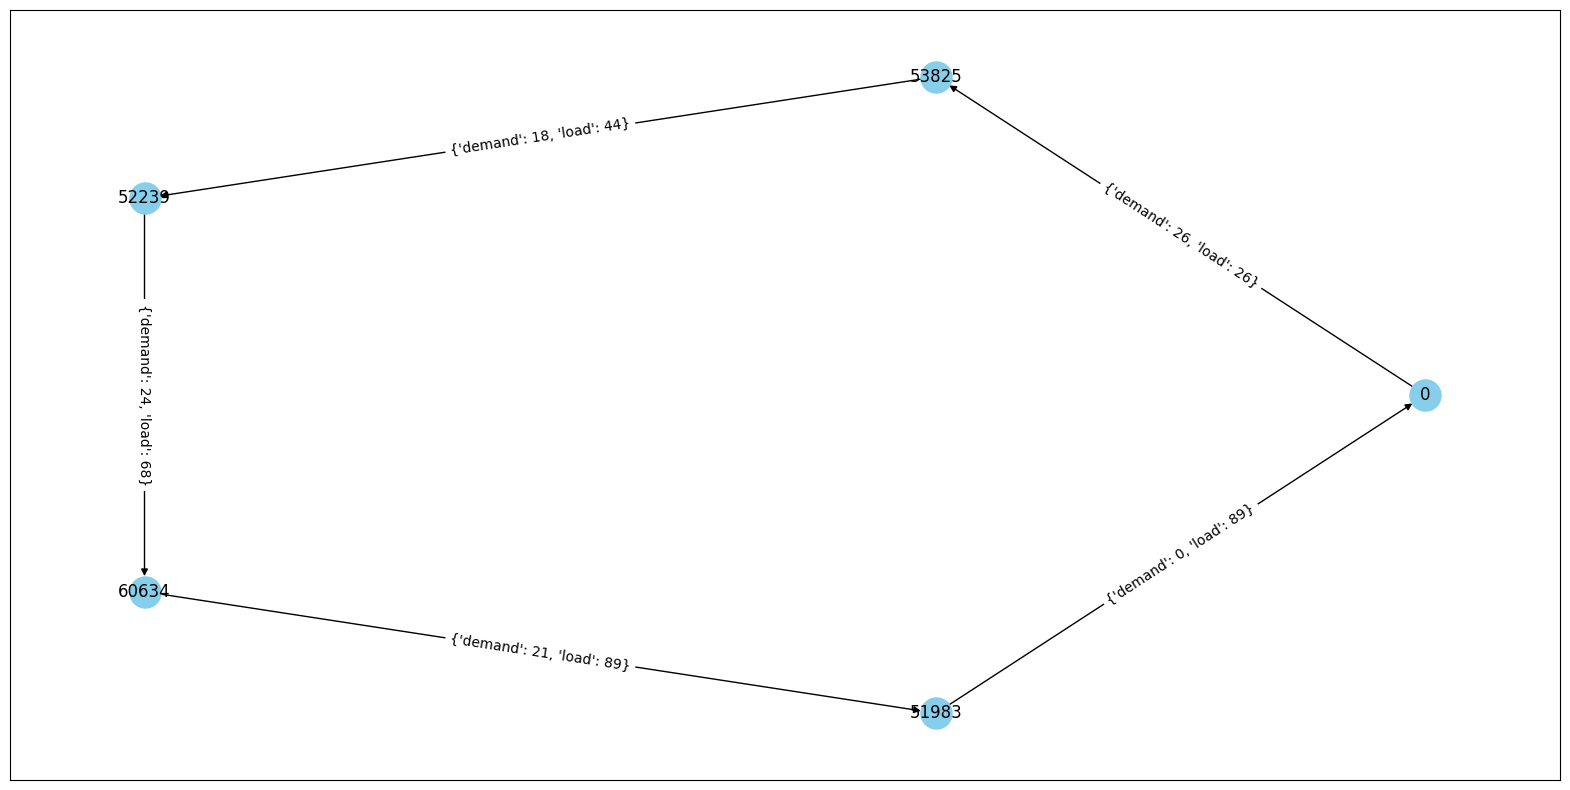



Bus 2:


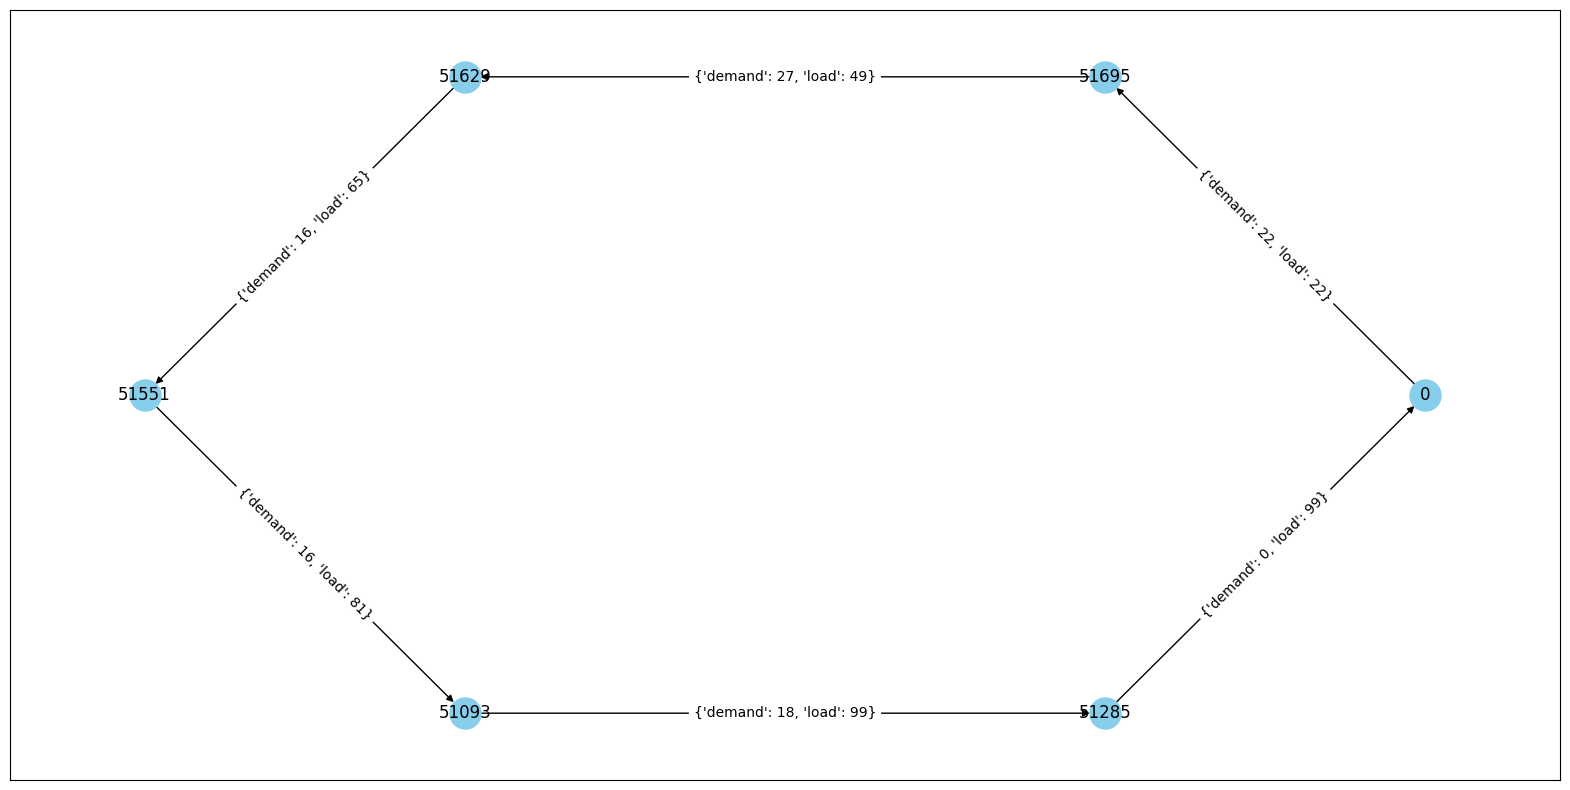



Bus 3:


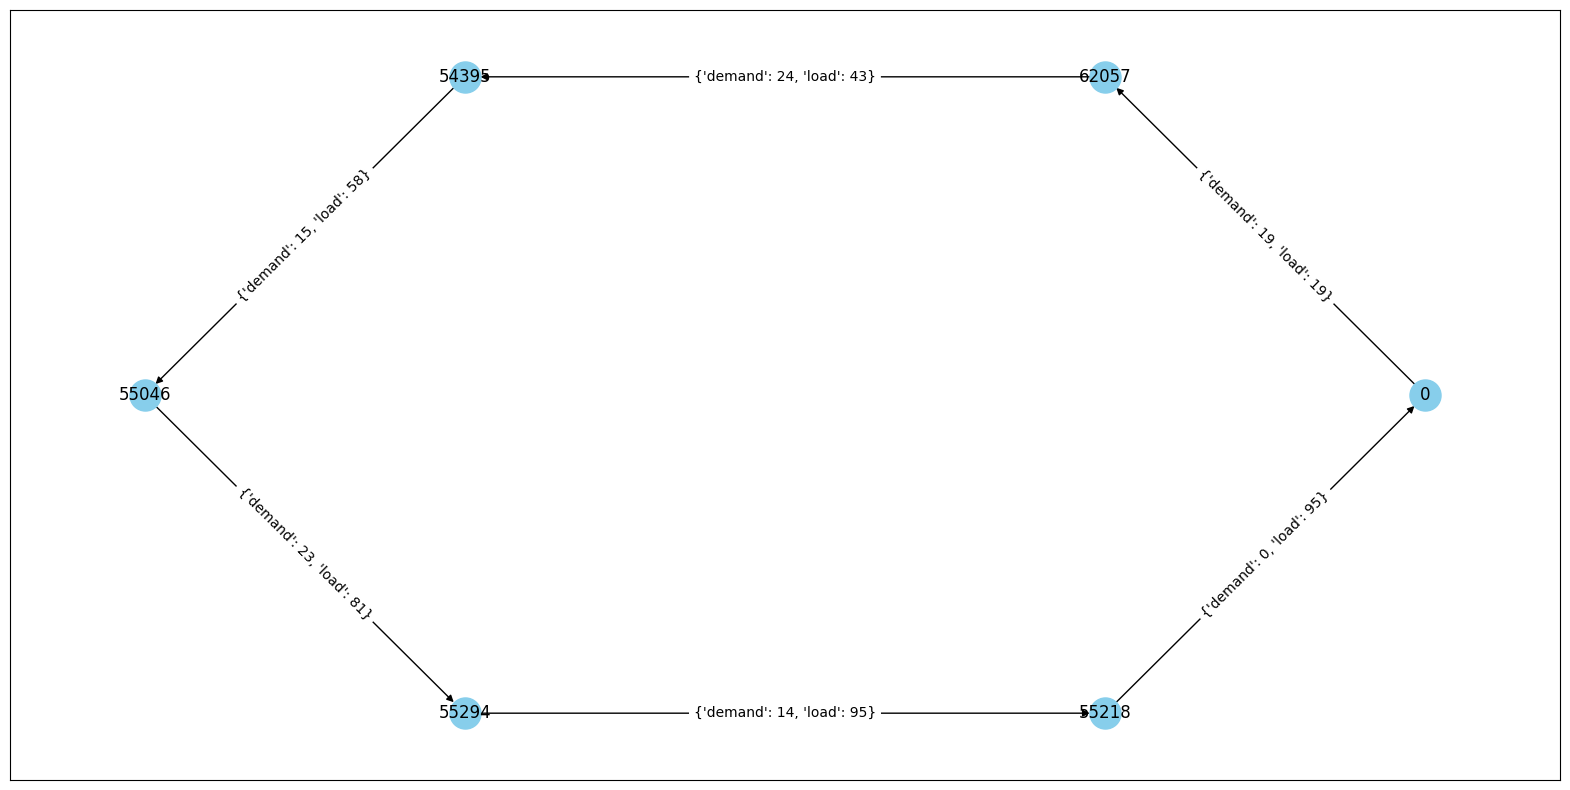



Bus 4:


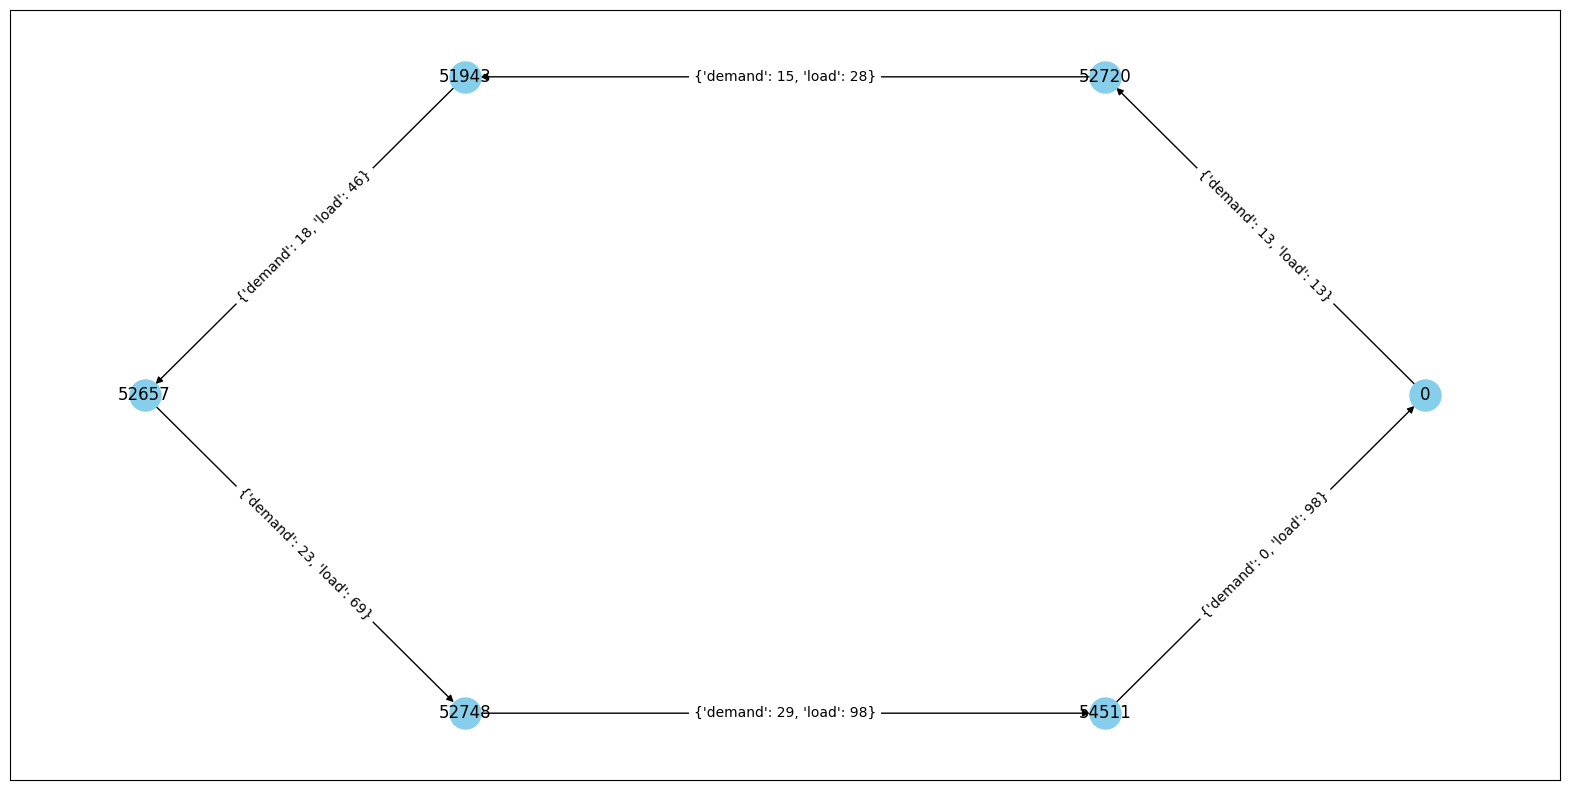



Bus 5:


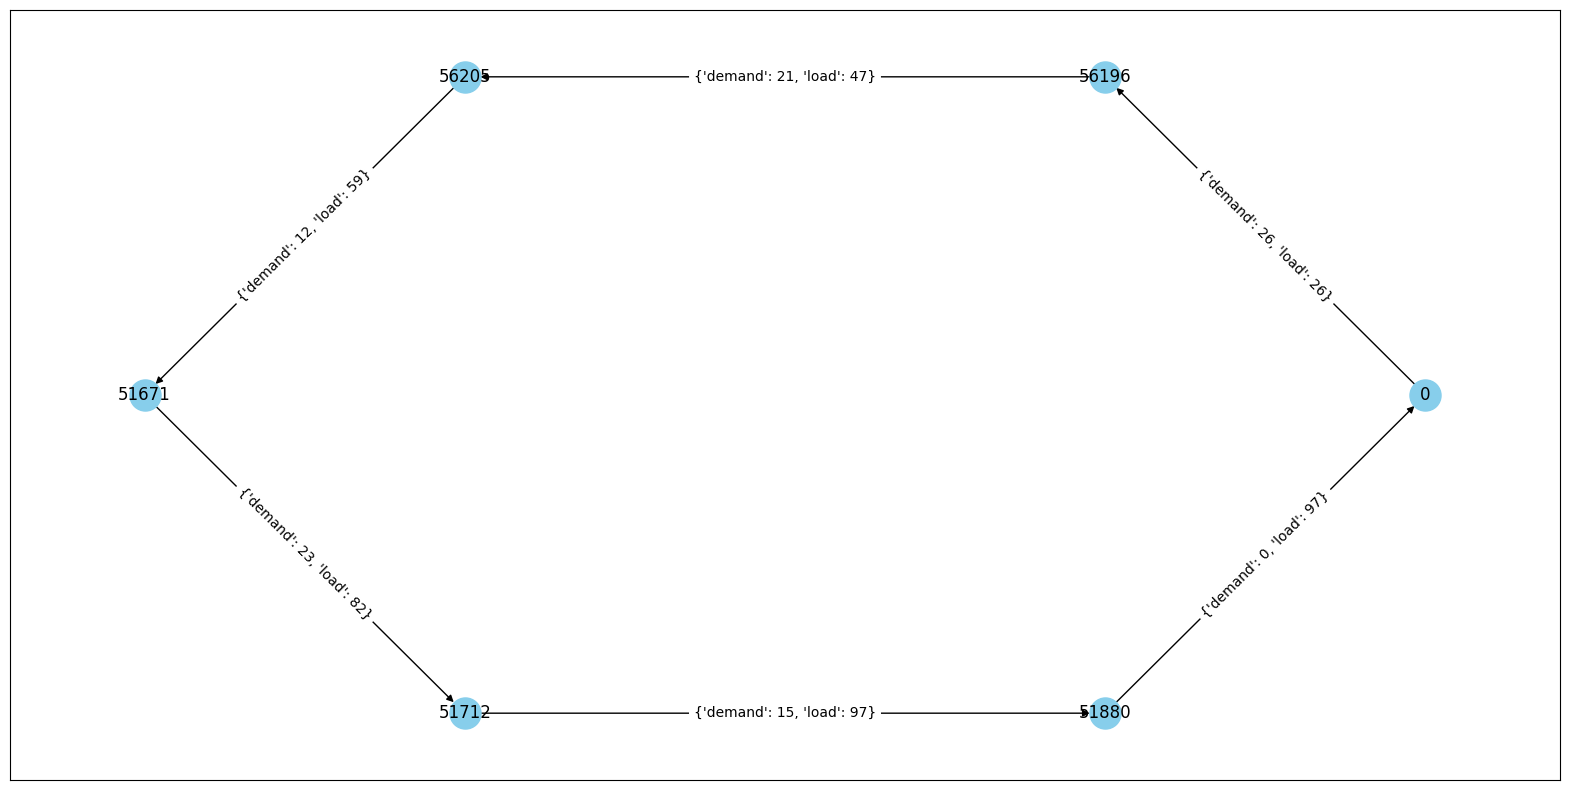



Bus 10:


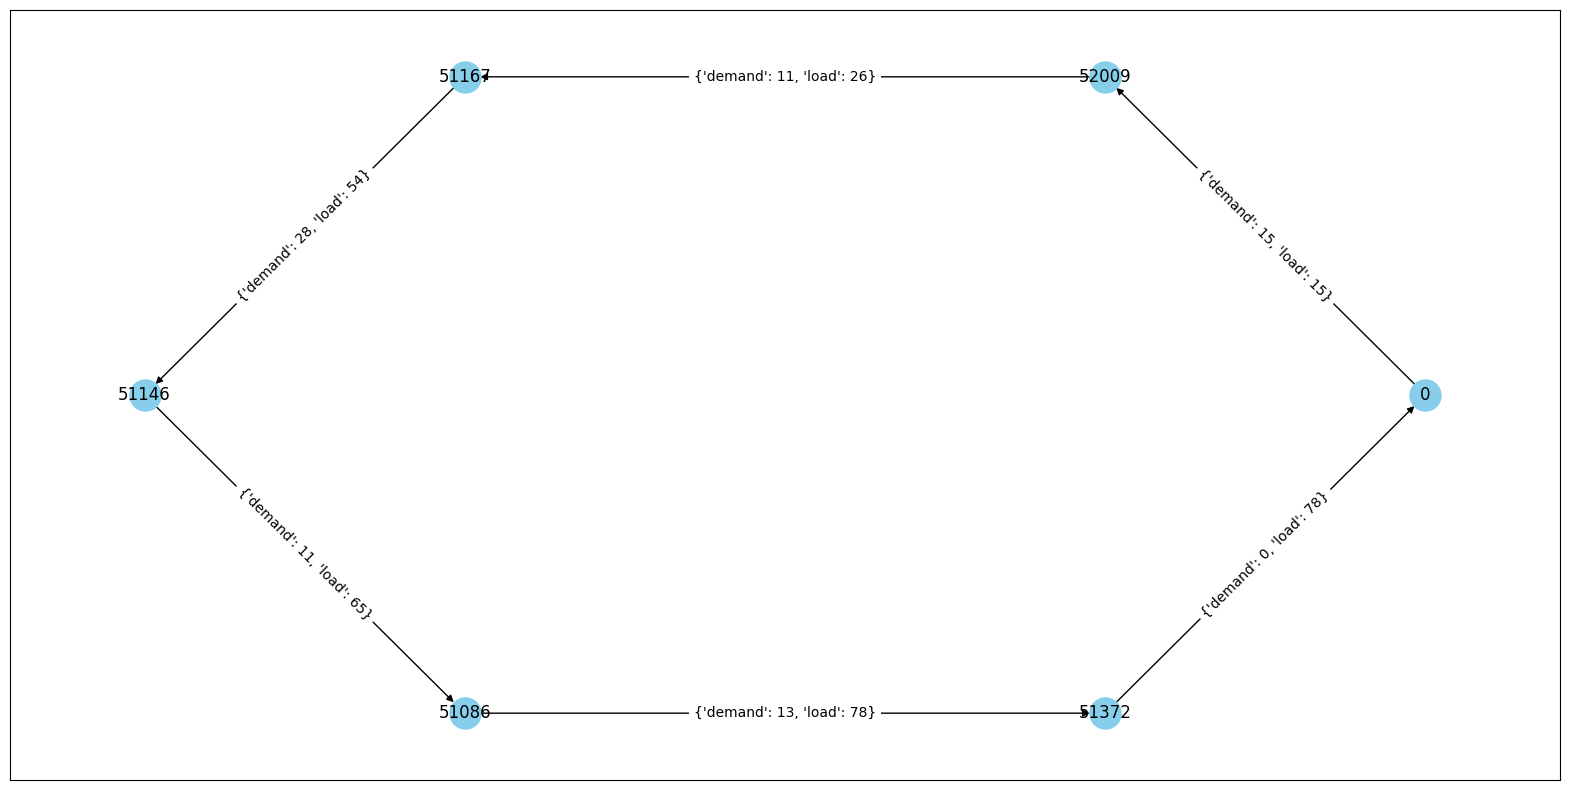

In [15]:
for bus in bus_path_df.bus.unique():
    print(f"Bus {bus + 1}:")

    bus_route = bus_path_df[bus_path_df["bus"] == bus].reset_index(drop=True)

    plt.figure(figsize=(20, 10))

    g = nx.DiGraph()

    for segment in bus_route.itertuples():
        g.add_edge(
            segment.start_stop,
            segment.end_stop,
            weight=segment.distance,
            demands={"demand": segment.demand, "load": segment.step_demand},
            step=segment.step,
            label=f"{segment.start_stop}-{segment.end_stop}",
            load=segment.step_demand,
        )

    pos = nx.circular_layout(g)

    nx.draw_networkx(g, pos, with_labels=True, node_size=500, node_color="skyblue")
    nx.draw_networkx_edge_labels(
        g, pos, edge_labels=nx.get_edge_attributes(g, "demands")
    )

    plt.show()

    print("\n")

In [16]:
routes_gdf = (
    gpd.GeoDataFrame(bus_path_df.groupby("bus")["geometry"].apply(list))
    .rename(columns={"points": "geometry"})
    .reset_index()
)

# add depot to each geometry
routes_gdf["points"] = routes_gdf.apply(
    lambda x: [Point((float(depot.stop_lon), float(depot.stop_lat)))] + x.geometry,
    axis=1,
)

routes_gdf["geometry"] = routes_gdf["points"].apply(LineString)
routes_gdf.drop(columns=["points"], inplace=True)

routes_gdf = routes_gdf.merge(
    bus_path_df.groupby("bus")["demand"].sum().rename("demand").reset_index(),
    on="bus",
)

routes_gdf = gpd.GeoDataFrame(routes_gdf, geometry="geometry")
routes_gdf.crs = "EPSG:4326"

routes_gdf

,bus,geometry,demand
0,0,"LINESTRING (-73.56912 45.50485, -73.56170 45.5...",89
1,1,"LINESTRING (-73.56912 45.50485, -73.59558 45.5...",99
2,2,"LINESTRING (-73.56912 45.50485, -73.62357 45.5...",95
3,3,"LINESTRING (-73.56912 45.50485, -73.56303 45.5...",98
4,4,"LINESTRING (-73.56912 45.50485, -73.61093 45.5...",97
5,9,"LINESTRING (-73.56912 45.50485, -73.58581 45.4...",78


### Map the routes

In [17]:
colormap = cm.get_cmap("tab10")

route_map = folium.Map(
    location=[45.5048542, -73.5691235],
    zoom_start=11,
    tiles="cartodbpositron",
    width="100%",
)

folium.GeoJson(
    disaster_area,
    name="Disaster area",
    style_function=lambda x: {
        "color": "#ff0000",
        "fillColor": "#ff0000",
        "weight": 1,
        "fillOpacity": 0.3,
    },
).add_to(route_map)

for stop in bus_path_df.itertuples():
    folium.CircleMarker(
        location=[stop.geometry.coords[0][1], stop.geometry.coords[0][0]],
        radius=5,
        color="#3186cc",
        fill=True,
        fill_opacity=1,
        fill_color="#3186cc",
        tooltip=f"""
        <b>{stop.stop_name} ({stop.stop_id})</b>
        <br>
        Route: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['bus'].values[0] + 1}
        <br>
        Step: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['step'].values[0] + 1}
        <br>
        Demand: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['demand'].values[0]}
        <br>
        Load: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['step_demand'].values[0]}
        """,
        popup=f"""
        <div>
            <h4>{stop.stop_name} ({stop.stop_id})</h4>
            <h4>Distance from depot: {distance_matrix.loc["0", stop.stop_id]:.1f} km</h4>
        </div>
        """,
    ).add_to(route_map)

for stop in stops_in_disaster_area.itertuples():
    folium.CircleMarker(
        location=[stop.geometry.coords[0][1], stop.geometry.coords[0][0]],
        radius=5,
        color="#3186cc",
        fill=True,
        fill_opacity=1,
        fill_color="#3186cc",
        tooltip=f"""
        <b>{stop.stop_name} ({stop.stop_id})</b>
        """,
        popup=f"""
        <div>
            <h4>{stop.stop_name} ({stop.stop_id})</h4>
            <h4>Distance from depot: {distance_matrix.loc["0", stop.stop_id]:.1f} km</h4>
        </div>
        """,
    ).add_to(route_map)


for route in routes_gdf.itertuples():
    route_layer = folium.FeatureGroup(name=f"Route {route.Index + 1}")

    folium.PolyLine(
        locations=[(p[1], p[0]) for p in route.geometry.coords],
        color=mcolors.rgb2hex(colormap.colors[route.Index]),
        weight=3,
        opacity=0.8,
        tooltip=f"Route {route.Index + 1}",
        popup=f"""
        <div>
            <h5>Route {route.Index + 1}</h5>
            <h5>Total demand: {route.demand}</h5>
        </div>
        """,
    ).add_to(route_layer)

    route_layer.add_to(route_map)

folium.plugins.Fullscreen(position="topright").add_to(route_map)
folium.plugins.MousePosition(position="topright").add_to(route_map)
folium.LayerControl().add_to(route_map)

route_map

## Split delivery vehicle routing problem - geometric split

### Parameters

In [122]:
rng = np.random.default_rng(5)

distance_matrix_model = distance_matrix.drop(
    columns=stops_in_disaster_area.stop_id, index=stops_in_disaster_area.stop_id
)

stops = list(distance_matrix_model.columns)
num_stops = len(stops)

distance_matrix_model = distance_matrix_model.loc[stops, stops]

demand_g = {stop: rng.integers(0, 100) for stop in stops}
demand_g[stops[0]] = 0


num_buses = 15
BUS_CAPACITY = 80

print(f"Total demand: {sum(demand.values())}")
print(f"Total capacity: {num_buses * BUS_CAPACITY}")

Total demand: 748
Total capacity: 1200


### Split demand nodes

$$
\begin{align*}
D_{ix} &= \frac{2^{x-1}}{\sum_{i=1}^{S} 2^{x-1}} D_{i}
\end{align*}
$$

$D_{ix}$ is rounded down to the nearest integer. If $\sum_{i=1}^{S} D_{ix} < D_{i}$, then $D_{iS} = D_{iS} + D_{i} - \sum_{i=1}^{S} D_{ix}$.

In [123]:
# Split the node demand into smaller demands according to a geometric progression

S = 100
fraction = [2 ** (i - 1) for i in range(1, S + 1)]
fraction_sum = sum(fraction)


def split_demand(node_demand):
    demands = [np.floor(node_demand * (f / fraction_sum)) for f in fraction]
    demands = list(filter(lambda x: x > 0, demands))

    if sum(demands) < node_demand:
        demands[-1] += node_demand - sum(demands)

    i = len(demands) - 1

    while demands[i] >= BUS_CAPACITY * 1:
        new_demand = split_demand(demands[i])
        demands.pop(i)
        demands.extend(new_demand)
        i -= 1

    return demands


def split_demand_node(demand, node):
    node_demand = demand[node]
    demands = split_demand(node_demand)

    return {f"{node}_{i}": d for i, d in enumerate(demands, 1)}

In [124]:
nodes_exceeding_demand = {}
new_demand = demand.copy()
for k, v in demand.items():
    if v > BUS_CAPACITY:
        new_nodes = split_demand_node(demand, k)

        new_demand.pop(k)
        new_demand.update(new_nodes)

        nodes_exceeding_demand[k] = new_nodes

print(f"New nodes added for: {list(nodes_exceeding_demand.keys())}")

# Update distance matrix to include split nodes. Distance between split nodes of same parent node is 0
for node in nodes_exceeding_demand:
    for i in range(1, len([k for k in new_demand.keys() if node in k]) + 1):
        distance_matrix_model[f"{node}_{i}"] = distance_matrix_model[node]
        distance_matrix_model.loc[f"{node}_{i}"] = distance_matrix_model.loc[node]
        distance_matrix_model.loc[f"{node}_{i}", node] = 0
    distance_matrix_model.drop(columns=[node], index=[node], inplace=True)


distance_matrix_model

New nodes added for: ['50804', '50986']


,0,52277,52129,51951,51032,56286,53353,54626,51819,51167,...,50804_3,50804_4,50804_5,50804_6,50986_1,50986_2,50986_3,50986_4,50986_5,50986_6
0,0.000000,0.861487,8.086734,2.383095,6.222221,2.627378,10.103120,11.594164,5.554667,4.975713,...,9.870764,9.870764,9.870764,9.870764,6.307561,6.307561,6.307561,6.307561,6.307561,6.307561
52277,0.861487,0.000000,8.346380,1.521608,5.360734,1.765891,10.362766,11.853810,5.814313,4.114226,...,10.130410,10.130410,10.130410,10.130410,5.446074,5.446074,5.446074,5.446074,5.446074,5.446074
52129,8.086734,8.346380,0.000000,9.833444,10.999515,10.077727,6.491115,4.264269,3.008662,8.737010,...,6.142800,6.142800,6.142800,6.142800,11.084855,11.084855,11.084855,11.084855,11.084855,11.084855
51951,2.383095,1.521608,9.833444,0.000000,5.004114,0.342071,11.883060,13.374104,7.334607,3.757606,...,11.606830,11.606830,11.606830,11.606830,5.089454,5.089454,5.089454,5.089454,5.089454,5.089454
51032,6.222221,5.360734,10.999515,5.004114,0.000000,4.374956,15.488320,15.295792,8.142425,2.090399,...,11.708845,11.708845,11.708845,11.708845,0.325754,0.325754,0.325754,0.325754,0.325754,0.325754
56286,2.627378,1.765891,10.077727,0.342071,4.374956,0.000000,12.145914,13.636958,7.325526,3.730018,...,11.579242,11.579242,11.579242,11.579242,5.061866,5.061866,5.061866,5.061866,5.061866,5.061866
53353,10.103120,10.362766,6.491115,11.883060,15.488320,12.145914,0.000000,4.391695,10.843957,15.929762,...,14.159826,14.159826,14.159826,14.159826,18.087623,18.087623,18.087623,18.087623,18.087623,18.087623
54626,11.594164,11.853810,4.264269,13.374104,15.295792,13.636958,4.391695,0.000000,7.315802,13.044150,...,9.824851,9.824851,9.824851,9.824851,15.391995,15.391995,15.391995,15.391995,15.391995,15.391995
51819,5.554667,5.814313,3.008662,7.334607,8.142425,7.325526,10.843957,7.315802,0.000000,6.064912,...,4.836060,4.836060,4.836060,4.836060,8.412757,8.412757,8.412757,8.412757,8.412757,8.412757
51167,4.975713,4.114226,8.737010,3.757606,2.090399,3.730018,15.929762,13.044150,6.064912,0.000000,...,9.645427,9.645427,9.645427,9.645427,2.404949,2.404949,2.404949,2.404949,2.404949,2.404949


In [125]:
for k, v in new_demand.items():
    assert v <= BUS_CAPACITY

assert sum(new_demand.values()) == sum(demand.values())

In [126]:
new_stops = list(distance_matrix_model.columns)
num_new_stops = len(new_stops)

print(f"Total number of stops (overall): {num_stops}")
print(f"Total number of stops (including splits): {num_new_stops}")

Total number of stops (overall): 20
Total number of stops (including splits): 30


### Model

In [17]:
# ----------------------------------------------------------------------------------------------
# Model

model = gb.Model("Bus Routing")
model.Params.MIPGap = 0.2
model.Params.TimeLimit = 60 * 3
model.Params.MIPFocus = 1


# ----------------------------------------------------------------------------------------------
# Decision Variables

x = model.addVars(
    new_stops,
    new_stops,
    num_buses,
    vtype=gb.GRB.BINARY,
    name=(
        f"{i} -> {j} (bus {k})" for i in new_stops for j in new_stops for k in range(num_buses)
    ),
)

u = model.addVars(
    new_stops,
    vtype=gb.GRB.INTEGER,
    name=(f"Load at Stop {i}" for i in new_stops),
)

# ----------------------------------------------------------------------------------------------
# Objective Function
model.setObjective(
    gb.quicksum(
        distance_matrix_model.loc[i, j] * x[i, j, k]
        for i in new_stops
        for j in new_stops
        for k in range(num_buses)
    ),
    gb.GRB.MINIMIZE,
)

# ----------------------------------------------------------------------------------------------
# Constraints

# Vehicle leaves nodes that it enters
model.addConstrs(
    (
        gb.quicksum(x[j, i, k] for j in new_stops) == gb.quicksum(x[i, j, k] for j in new_stops)
        for i in new_stops
        for k in range(num_buses)
    ),
    name="Vehicle leaves nodes that it enters",
)

# Every node is entered once
model.addConstrs(
    (
        gb.quicksum(x[i, j, k] for i in new_stops for k in range(num_buses)) == 1
        for j in new_stops[1:]
    ),
    name="Every node is entered once",
)

# Every vehicle leaves the depot
model.addConstrs(
    (gb.quicksum(x[new_stops[0], j, k] for j in new_stops[1:]) <= 1 for k in range(num_buses)),
    name="Every vehicle may leave the depot if needed",
)

# Capacity constraint
model.addConstrs(
    (
        gb.quicksum(new_demand[j] * x[i, j, k] for j in new_stops[1:] for i in new_stops)
        <= BUS_CAPACITY
        for k in range(num_buses)
    ),
    name="Capacity constraint",
)

# No travel between same node
model.addConstrs(
    (x[i, i, k] == 0 for i in new_stops for k in range(num_buses)),
    name="No same node",
)

# Subtour elimination constraints
model.addConstrs(
    (
        u[j] - u[i] >= new_demand[j] - BUS_CAPACITY * (1 - x[i, j, k])
        for i in new_stops[1:]
        for j in new_stops[1:]
        for k in range(num_buses)
        if i != j
    ),
    name="Subtour elimination constraint",
)

model.addConstrs(
    (u[i] >= new_demand[i] for i in new_stops[1:]),
    name="Lower bound for u",
)

model.addConstrs(
    (u[i] <= BUS_CAPACITY for i in new_stops[1:]),
    name="Upper bound for u",
)

# Distance between two travel nodes is less than specified distance
model.addConstrs(
    (
        distance_matrix_model.loc[i, j] * x[i, j, k] <= 10
        for i in new_stops[1:]
        for j in new_stops[1:]
        for k in range(num_buses)
    ),
    name="Distance between two travel nodes is less than a specified distance",
)

# ----------------------------------------------------------------------------------------------
# Solve model
model.update()
model.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-30
Set parameter MIPGap to value 0.2
Set parameter TimeLimit to value 180
Set parameter MIPFocus to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 22416 rows, 11788 columns and 87339 nonzeros
Model fingerprint: 0x7c80b124
Variable types: 0 continuous, 11788 integer (11760 binary)
Coefficient statistics:
  Matrix range     [3e-01, 8e+01]
  Objective range  [3e-01, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+01]
Presolve removed 16539 rows and 5553 columns
Presolve time: 0.12s
Presolved: 5877 rows, 6235 columns, 40515 nonzeros
Variable types: 0 continuous, 6235 integer (6210 binary)

Root relaxation: objective 5.497316e+01, 677 iterations, 0.03 seconds (0.02 work units)

  

### Optimal solution routes

In [112]:
print(f"Objective value: {model.objVal:.2f} km")

# Distance by bus
distance_bus = pd.DataFrame(
    {
        "bus": k,
        "distance": sum(
            distance_matrix_model.loc[i, j] * x[i, j, k].x
            for i in new_stops
            for j in new_stops
        ),
    }
    for k in range(num_buses)
)

distance_bus = distance_bus[distance_bus["distance"] > 0].reset_index(drop=True)

display(distance_bus)

# Bus paths
bus_path = {}

for k in range(num_buses):
    bus_path[k] = []
    for i in new_stops:
        for j in new_stops:
            if x[i, j, k].x == 1:
                bus_path[k].append(
                    {
                        "start_stop": i,
                        "end_stop": j,
                        "distance": distance_matrix_model.loc[i, j],
                    }
                )

# Convert to dataframe with bus route number
bus_path_df = []

for k, v in bus_path.items():
    bus_path_df.append(pd.DataFrame(v).assign(bus=k))

bus_path_df = pd.concat(bus_path_df)

paths = {}

grouped = bus_path_df.groupby("bus")

# Iterate over each bus group
for bus, group in grouped:
    sorted_group = group.sort_values(by=["start_stop", "end_stop"]).reset_index(
        drop=True
    )
    path = ["0"]  # Initialize the path with the depot

    # Start with the first stop after the depot
    current_stop = sorted_group.loc[
        sorted_group["start_stop"] == "0", "end_stop"
    ].values[0]
    path.append(current_stop)

    # Follow the chain of stops
    while True:
        # Find the next stop where the current stop is the start stop
        next_stop = sorted_group.loc[
            sorted_group["start_stop"] == current_stop, "end_stop"
        ].values
        if not next_stop:
            break  # If there is no next stop, we've completed the path
        next_stop = next_stop[0]

        # Add the next stop to the path and set it as the current stop
        if next_stop == "0":
            break  # If the next stop is the depot, we've completed the path
        path.append(next_stop)
        current_stop = next_stop

    # Store the path for this bus
    paths[bus] = path

bus_path_df["step"] = bus_path_df.apply(
    lambda x: paths[x.bus].index(x.start_stop), axis=1
)

bus_path_df.sort_values(by=["bus", "step"], inplace=True)

bus_path_df["demand"] = bus_path_df["end_stop"].map(new_demand)

bus_path_df[["start_stop", "end_stop"]] = bus_path_df[
    ["start_stop", "end_stop"]
].applymap(lambda x: x.split("_")[0])


bus_path_df = bus_path_df.merge(
    random_stops_df_gpd[["stop_id", "stop_name", "geometry"]],
    left_on="end_stop",
    right_on="stop_id",
    how="left",
)


bus_path_df["step_demand"] = bus_path_df.groupby("bus")["demand"].cumsum()

num_buses_used = bus_path_df.bus.nunique()
print(f"Number of buses used: {num_buses_used}")

display(bus_path_df)

# Print routes
for route in paths:
    print(f"Route {route +  1}: {' -> '.join(paths[route])} -> 0")

Objective value: 137.94 km


,bus,distance
0,0,1.722974
1,1,4.766190
2,2,12.615122
3,3,19.741528
4,4,37.481962
5,5,12.855536
6,6,11.125555
7,7,1.215786
8,11,10.953725
9,13,20.206240


Number of buses used: 11


,start_stop,end_stop,distance,bus,step,demand,stop_id,stop_name,geometry,step_demand
0,0,52277,0.861487,0,0,80,52277,Sherbrooke / Peel,POINT (-73.57663 45.50163),80
1,52277,0,0.861487,0,1,0,0,Depot,POINT (-73.56912 45.50485),80
2,0,51951,2.383095,1,0,80,51951,Sherbrooke / Atwater,POINT (-73.58804 45.49107),80
3,51951,0,2.383095,1,1,0,0,Depot,POINT (-73.56912 45.50485),80
4,0,50986,6.307561,2,0,80,50986,Queen-Mary / Earnscliffe,POINT (-73.63058 45.48183),80
5,50986,0,6.307561,2,1,0,0,Depot,POINT (-73.56912 45.50485),80
6,0,50804,9.870764,3,0,80,50804,Papineau / Legendre,POINT (-73.63610 45.56089),80
7,50804,0,9.870764,3,1,0,0,Depot,POINT (-73.56912 45.50485),80
8,0,51576,3.389347,4,0,14,51576,du Parc / Saint-Viateur,POINT (-73.60201 45.52220),14
9,51576,51093,2.038659,4,1,4,51093,Station Parc (Hutchison / Ogilvy),POINT (-73.62426 45.53017),18


Route 1: 0 -> 52277 -> 0
Route 2: 0 -> 51951 -> 0
Route 3: 0 -> 50986_1 -> 0
Route 4: 0 -> 50804_1 -> 0
Route 5: 0 -> 51576 -> 51093 -> 52129 -> 54626 -> 55078 -> 50555 -> 50804_2 -> 0
Route 6: 0 -> 50986_2 -> 51032 -> 0
Route 7: 0 -> 51167 -> 56188 -> 0
Route 8: 0 -> 52335 -> 0
Route 12: 0 -> 51819 -> 52022 -> 52459 -> 0
Route 14: 0 -> 53353 -> 0
Route 15: 0 -> 56286 -> 0


Bus 1:


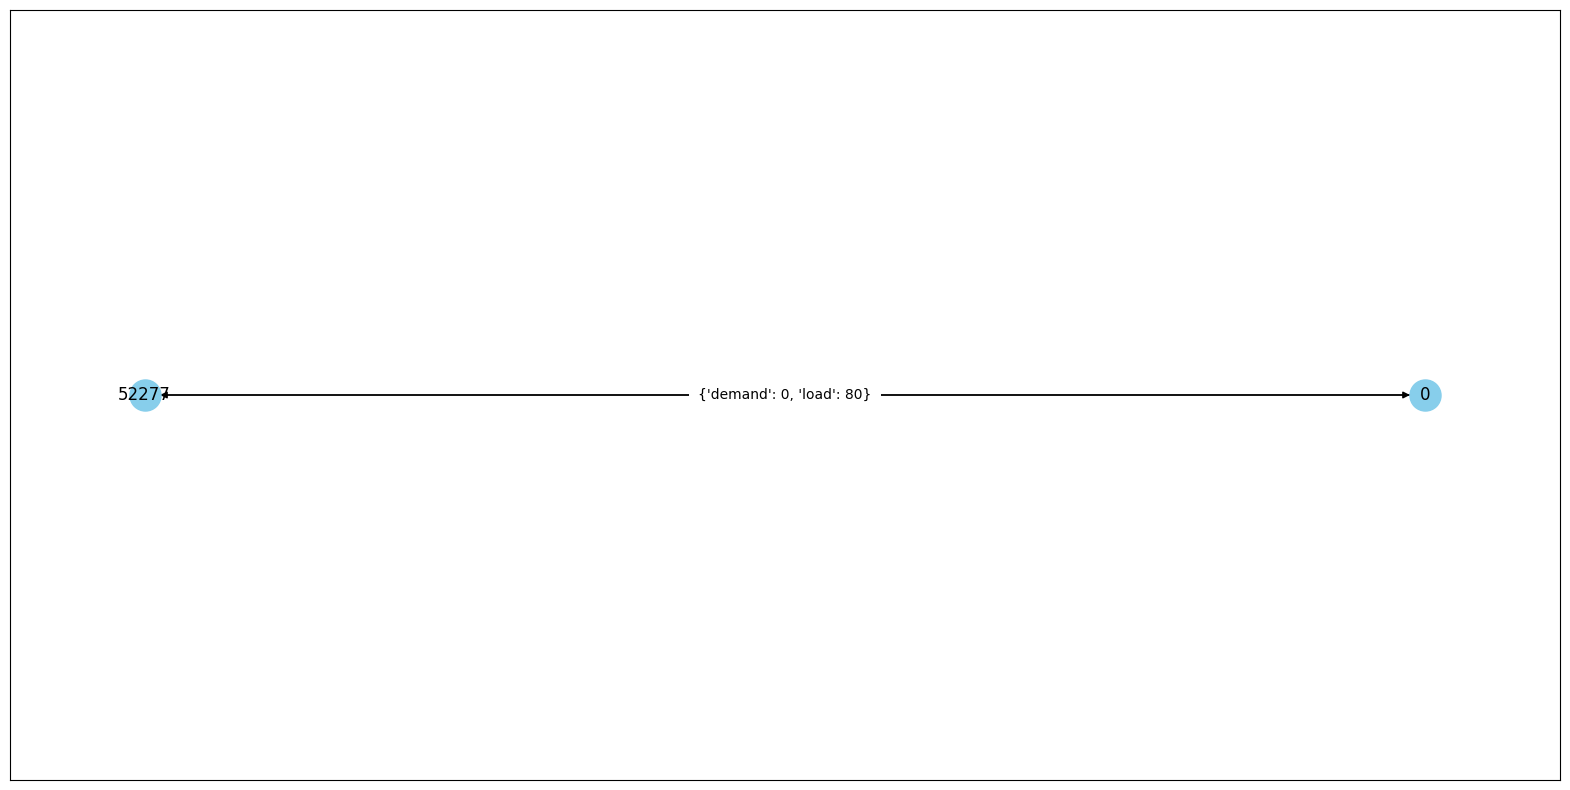



Bus 2:


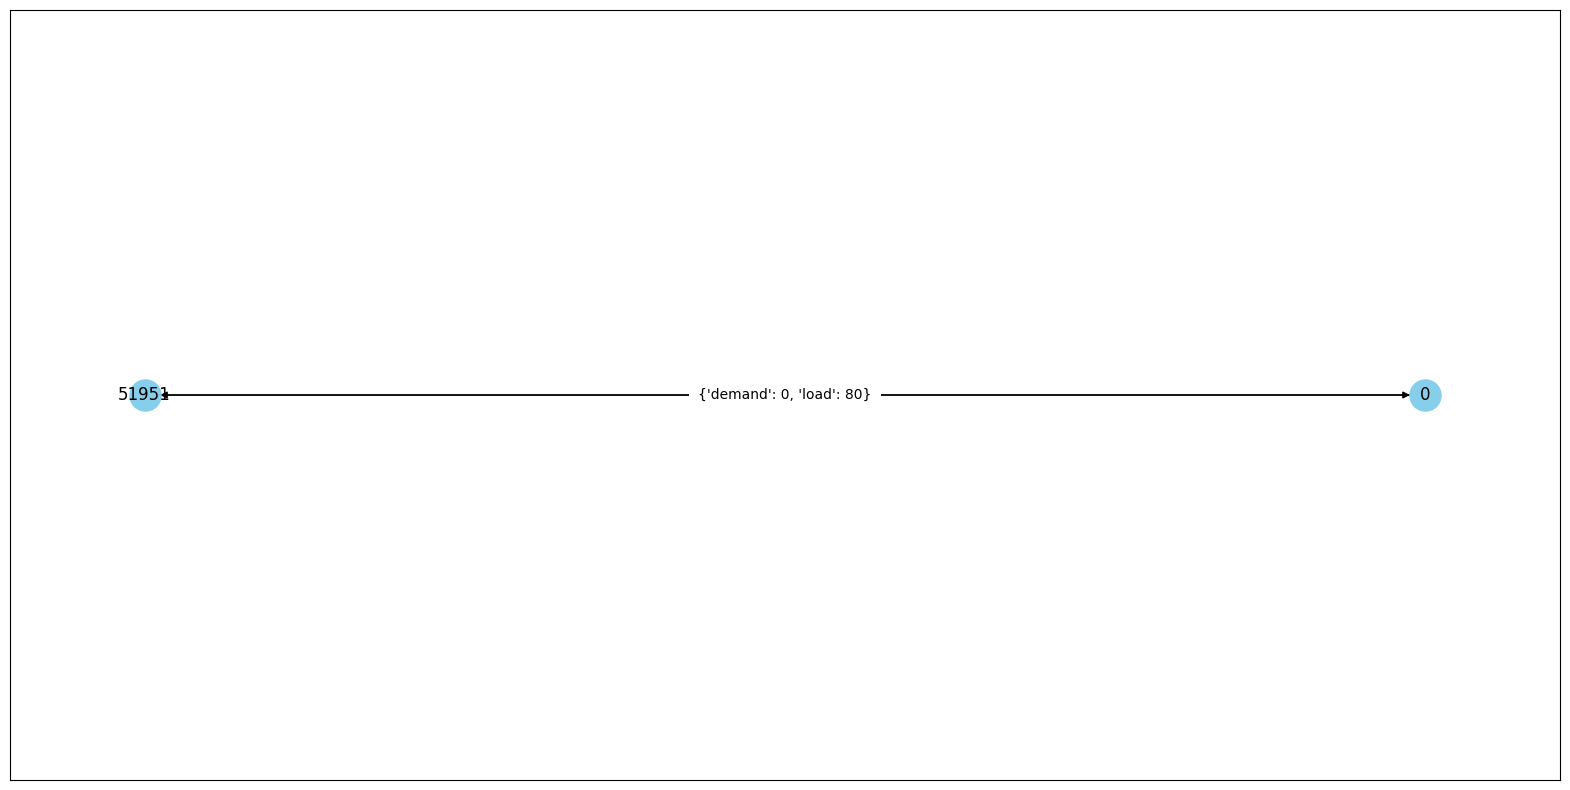



Bus 3:


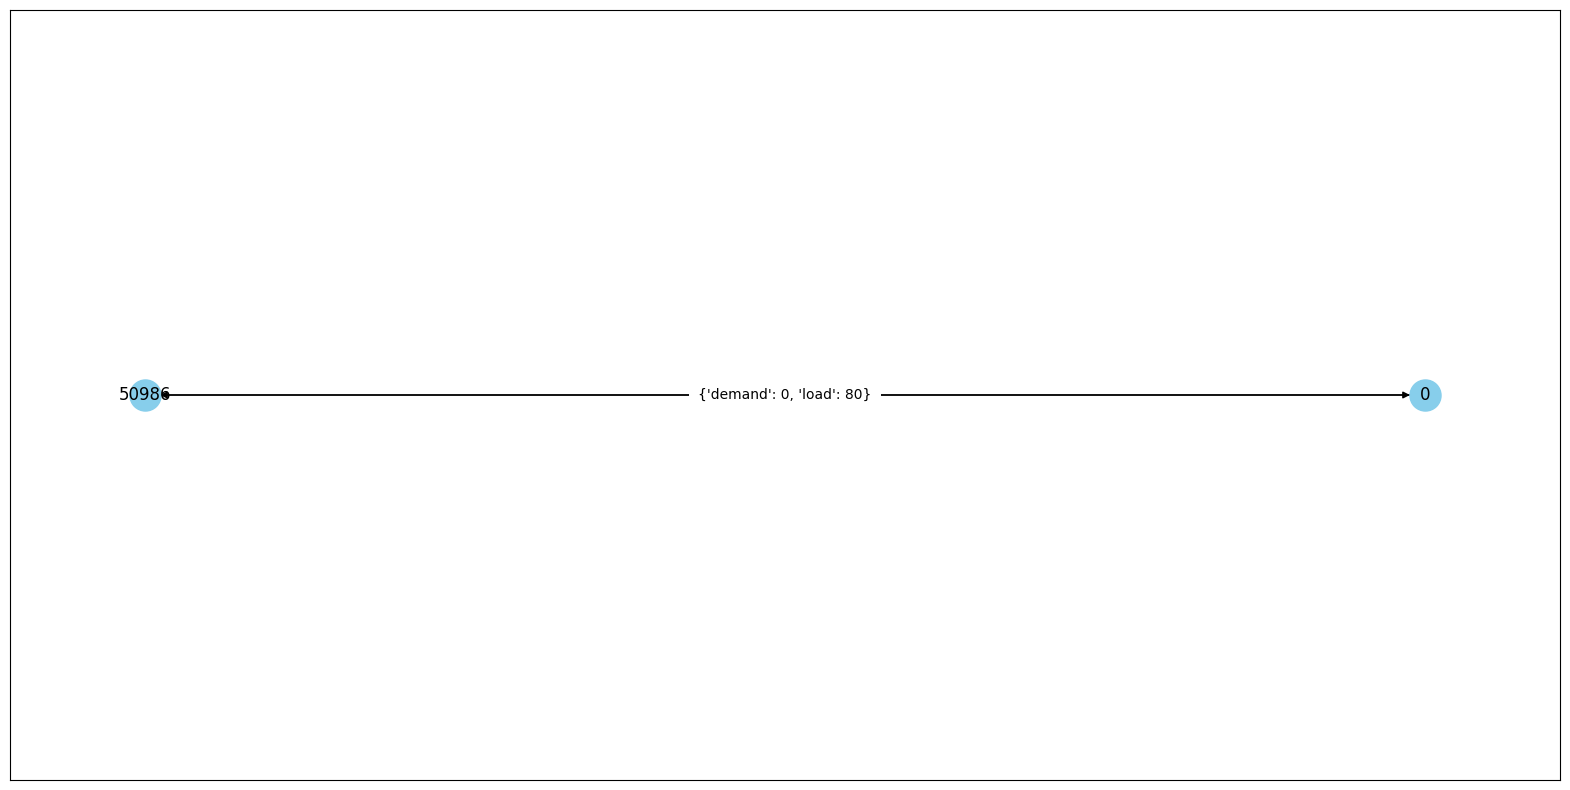



Bus 4:


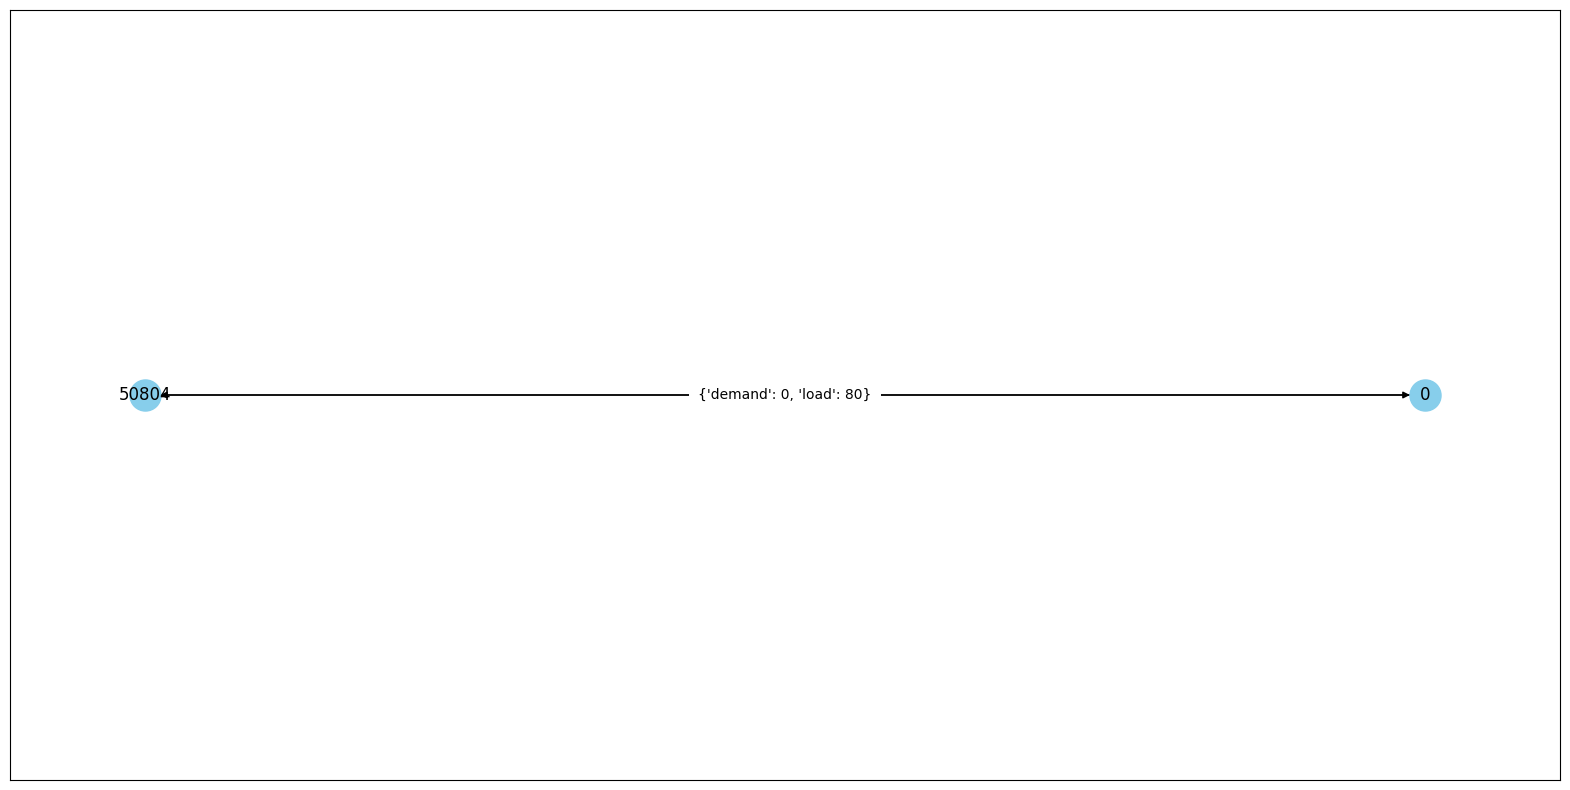



Bus 5:


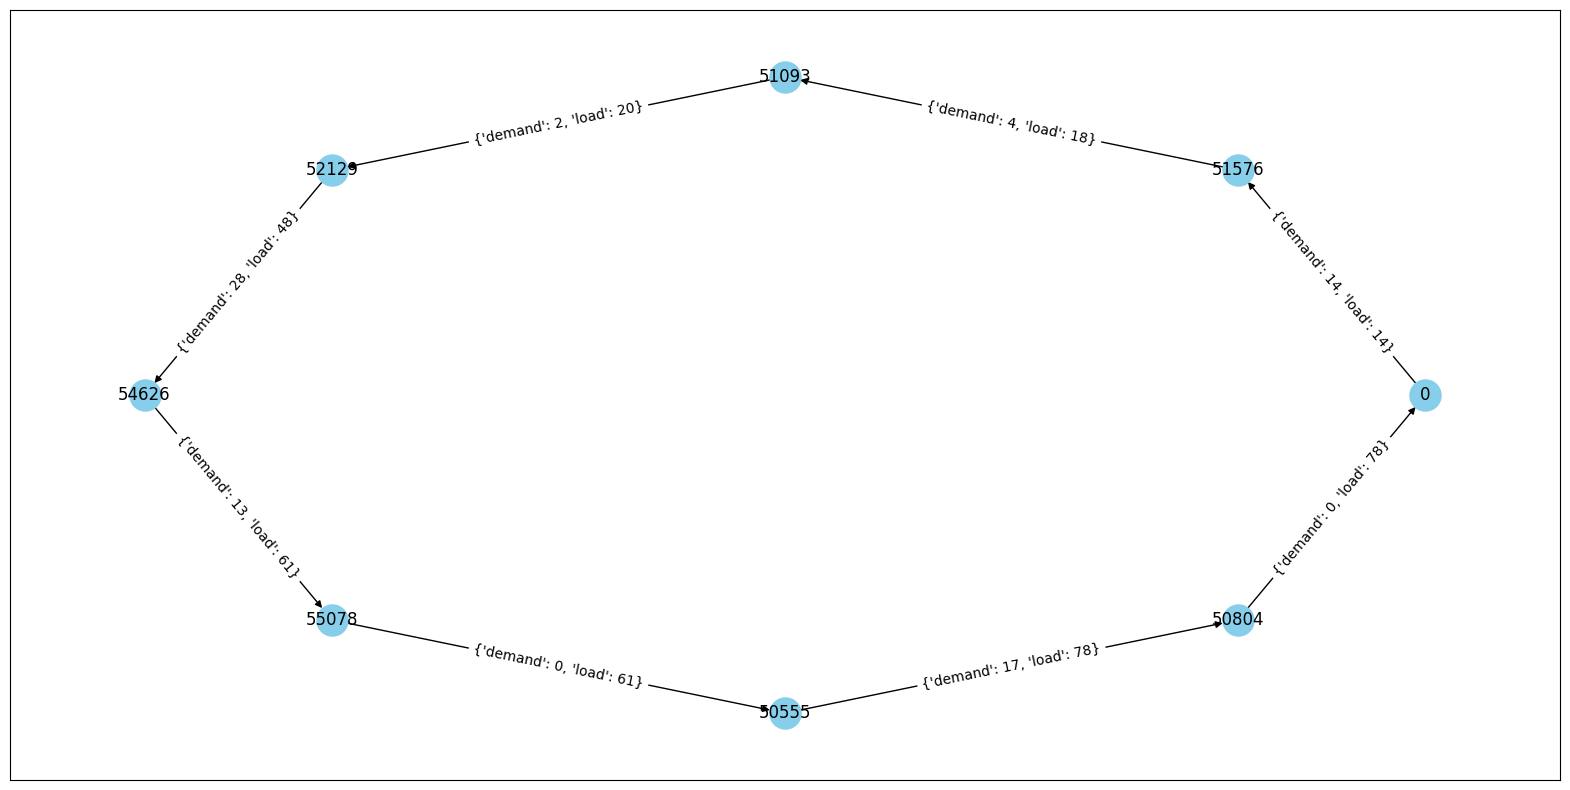



Bus 6:


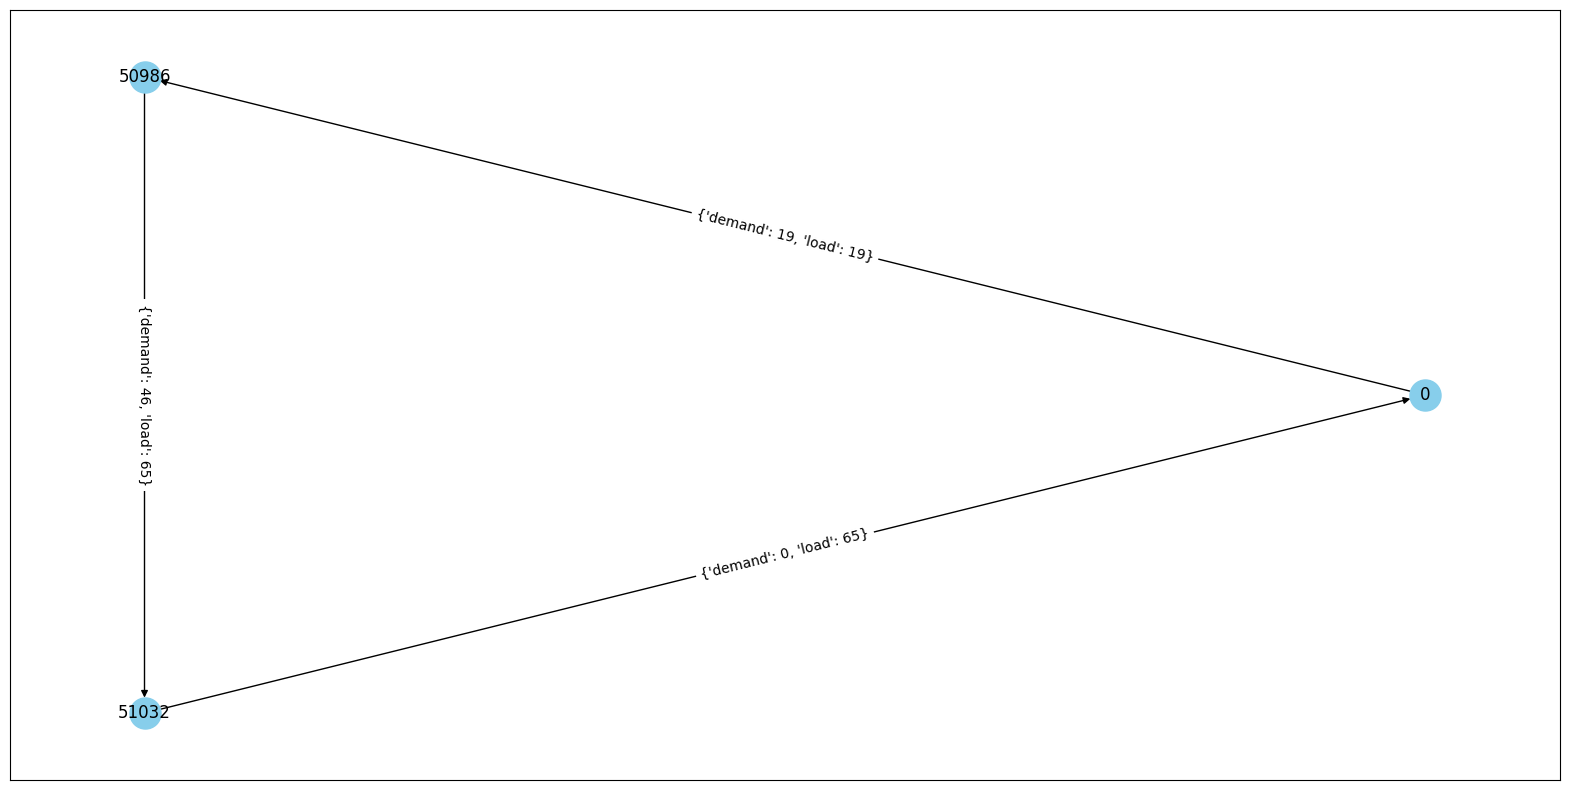



Bus 7:


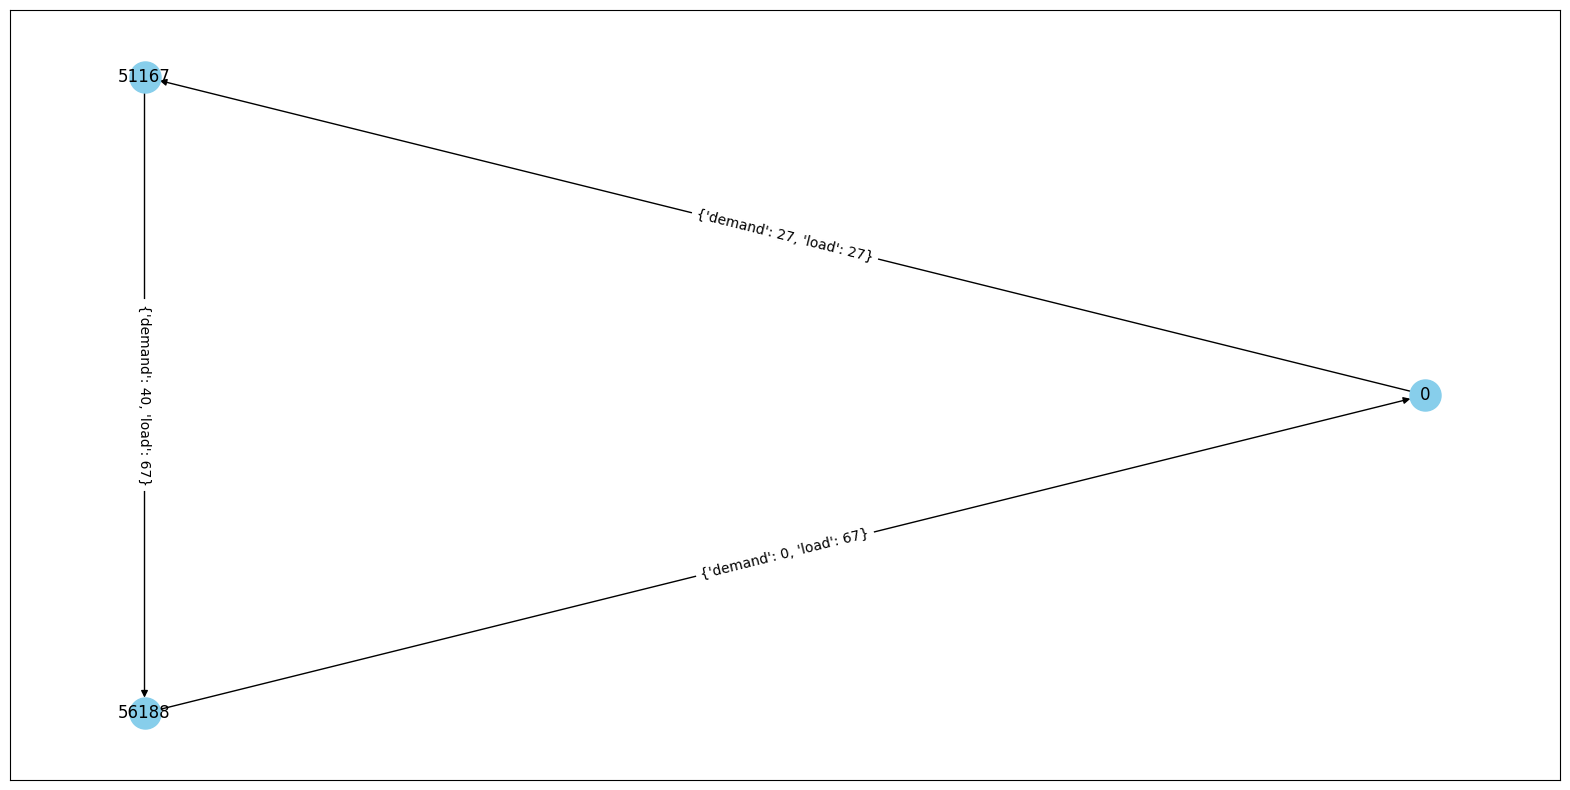



Bus 8:


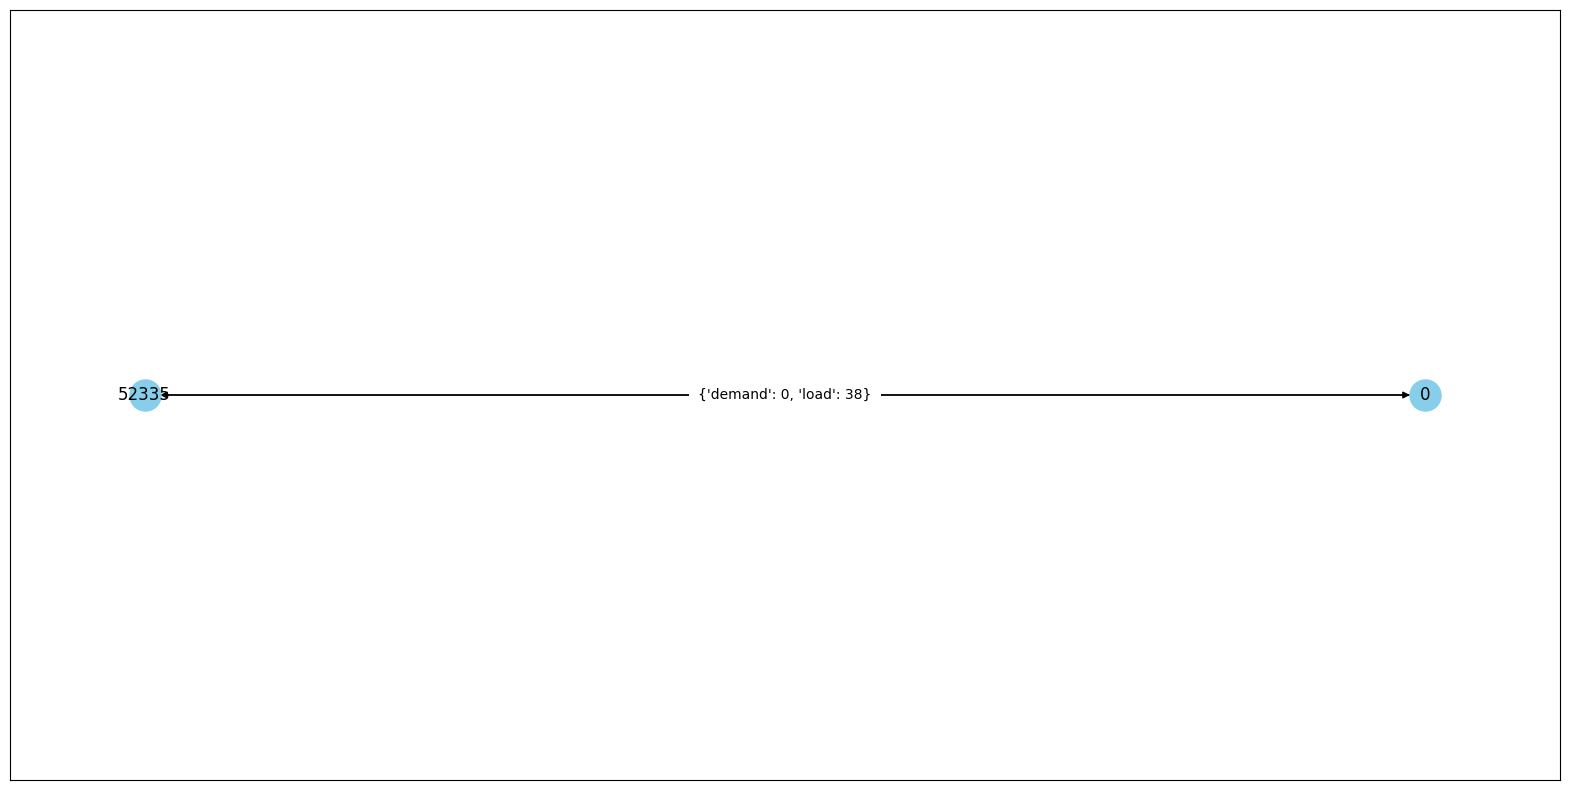



Bus 12:


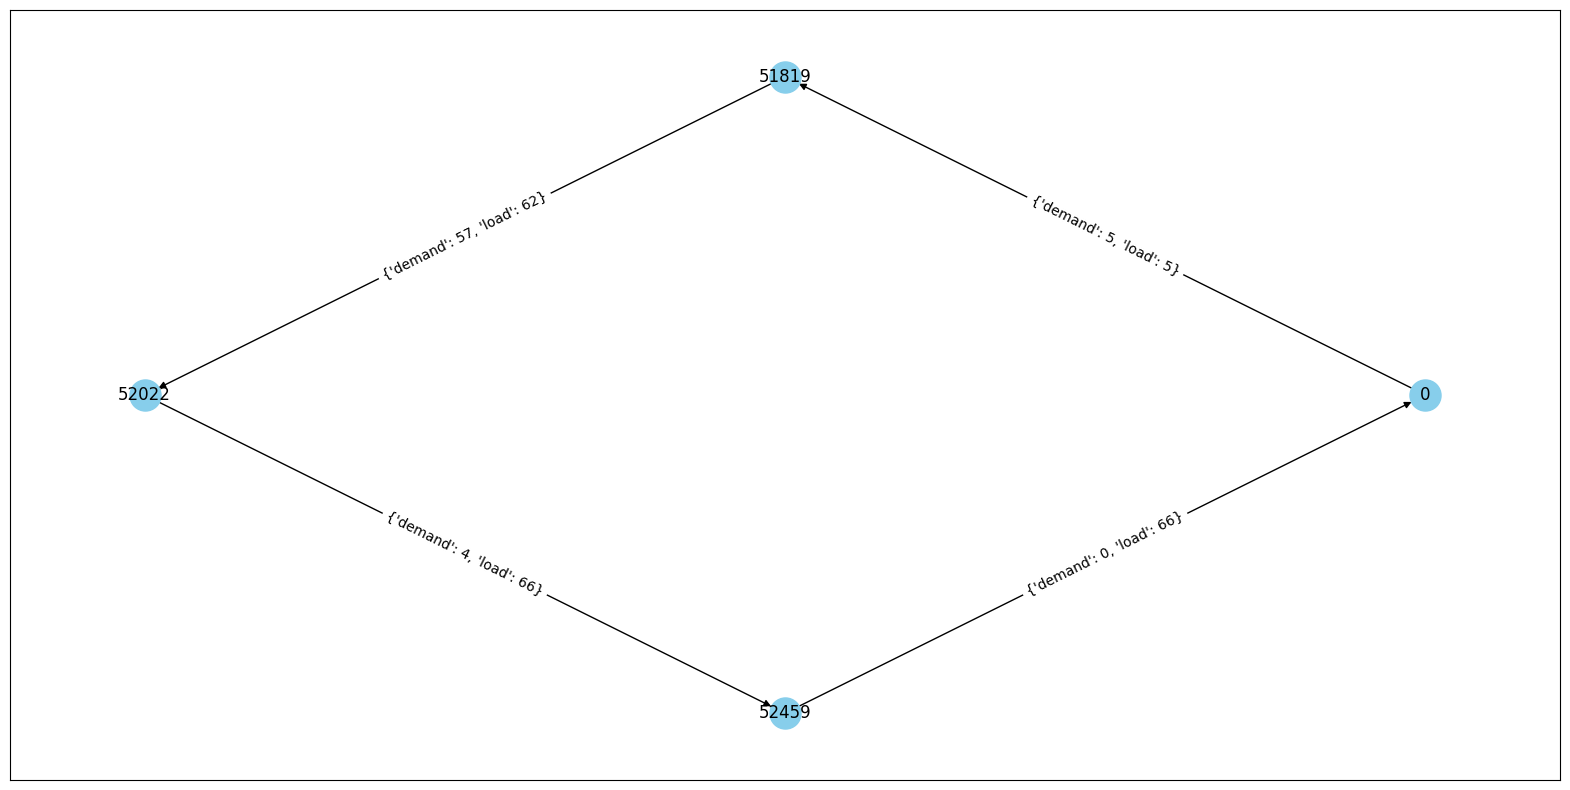



Bus 14:


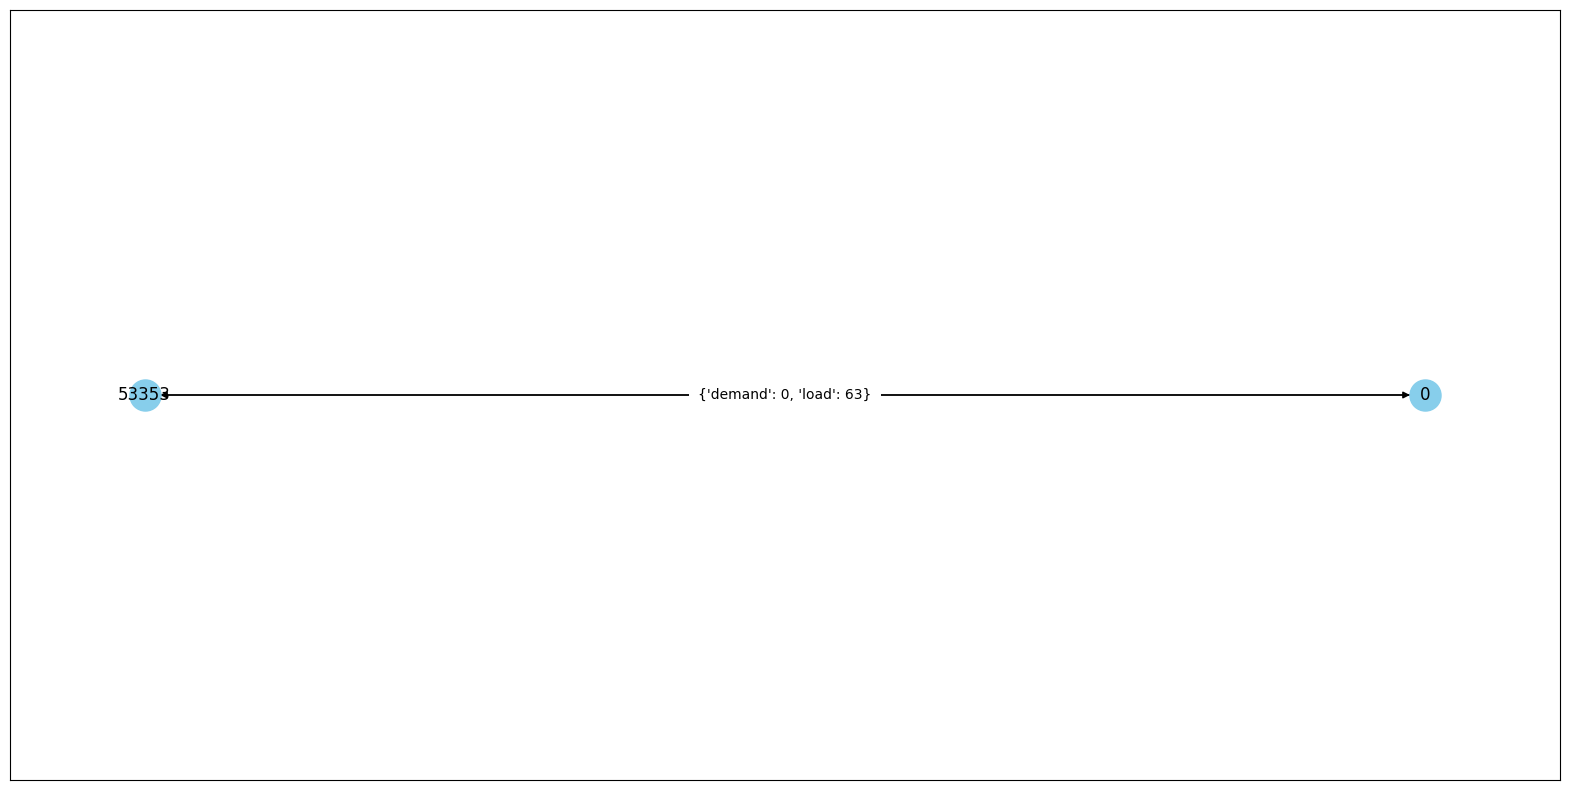



Bus 15:


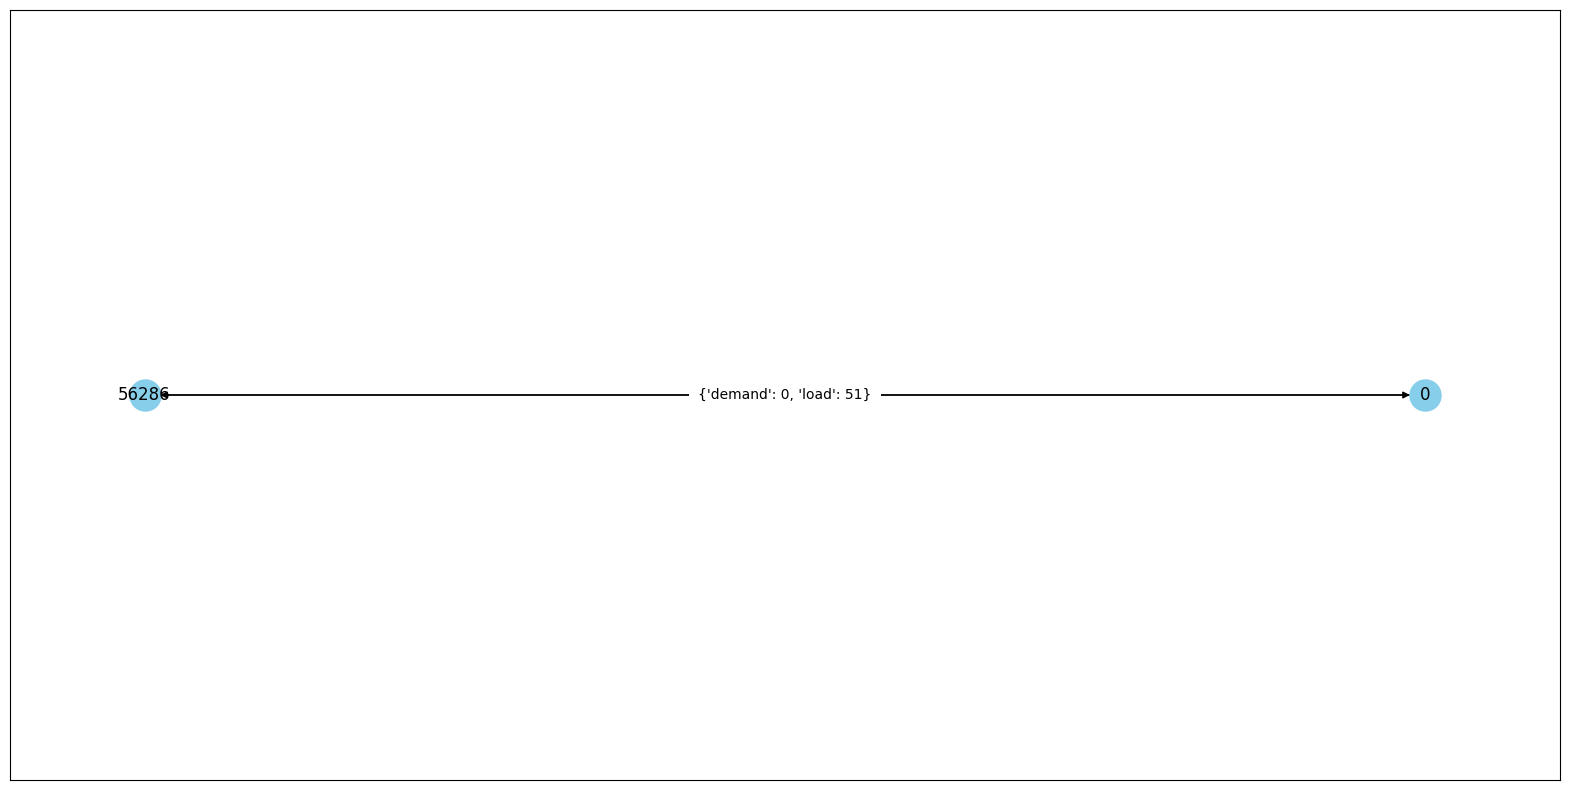

In [110]:
for bus in bus_path_df.bus.unique():
    print(f"Bus {bus + 1}:")

    bus_route = bus_path_df[bus_path_df["bus"] == bus].reset_index(drop=True)

    plt.figure(figsize=(20, 10))

    g = nx.DiGraph()

    for segment in bus_route.itertuples():
        g.add_edge(
            segment.start_stop,
            segment.end_stop,
            weight=segment.distance,
            demands={"demand": segment.demand, "load": segment.step_demand},
            step=segment.step,
            label=f"{segment.start_stop}-{segment.end_stop}",
            load=segment.step_demand,
        )

    pos = nx.circular_layout(g)

    nx.draw_networkx(g, pos, with_labels=True, node_size=500, node_color="skyblue")
    nx.draw_networkx_edge_labels(
        g, pos, edge_labels=nx.get_edge_attributes(g, "demands")
    )

    plt.show()

    print("\n")

In [113]:
routes_gdf = (
    gpd.GeoDataFrame(bus_path_df.groupby("bus")["geometry"].apply(list))
    .rename(columns={"points": "geometry"})
    .reset_index()
)

# add depot to each geometry
routes_gdf["points"] = routes_gdf.apply(
    lambda x: [Point((float(depot.stop_lon), float(depot.stop_lat)))] + x.geometry,
    axis=1,
)

routes_gdf["geometry"] = routes_gdf["points"].apply(LineString)
routes_gdf.drop(columns=["points"], inplace=True)

routes_gdf = routes_gdf.merge(
    bus_path_df.groupby("bus")["demand"].sum().rename("demand").reset_index(),
    on="bus",
)

routes_gdf = gpd.GeoDataFrame(routes_gdf, geometry="geometry")
routes_gdf.crs = "EPSG:4326"

display(routes_gdf)

,bus,geometry,demand
0,0,"LINESTRING (-73.56912 45.50485, -73.57663 45.5...",80
1,1,"LINESTRING (-73.56912 45.50485, -73.58804 45.4...",80
2,2,"LINESTRING (-73.56912 45.50485, -73.63058 45.4...",80
3,3,"LINESTRING (-73.56912 45.50485, -73.63610 45.5...",80
4,4,"LINESTRING (-73.56912 45.50485, -73.60201 45.5...",78
5,5,"LINESTRING (-73.56912 45.50485, -73.63058 45.4...",65
6,6,"LINESTRING (-73.56912 45.50485, -73.62216 45.4...",67
7,7,"LINESTRING (-73.56912 45.50485, -73.57477 45.5...",38
8,11,"LINESTRING (-73.56912 45.50485, -73.59108 45.5...",66
9,13,"LINESTRING (-73.56912 45.50485, -73.52561 45.5...",63


### Map the routes

In [115]:
colormap_route = [
    mcolors.rgb2hex(c) for c in list(plt.cm.rainbow(np.linspace(0, 1, num_buses)))
]

route_map = folium.Map(
    location=[45.5048542, -73.5691235],
    zoom_start=11,
    tiles="cartodbpositron",
    width="100%",
)

folium.GeoJson(
    disaster_area,
    name="Disaster area",
    style_function=lambda x: {
        "color": "#ff0000",
        "fillColor": "#ff0000",
        "weight": 1,
        "fillOpacity": 0.3,
    },
).add_to(route_map)

for stop in bus_path_df.itertuples():
    folium.CircleMarker(
        location=[stop.geometry.coords[0][1], stop.geometry.coords[0][0]],
        radius=5,
        color=colormap_route[stop.bus] if stop.stop_id != "0" else "black",
        fill=True,
        fill_opacity=1,
        fill_color=colormap_route[stop.bus] if stop.stop_id != "0" else "black",
        tooltip=f"""
        <b>{stop.stop_name} ({stop.stop_id})</b>
        <br>
        Route: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['bus'].values[0] + 1}
        <br>
        Step: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['step'].values[0] + 1}
        <br>
        Demand: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['demand'].values[0]}
        <br>
        Load: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['step_demand'].values[0]}
        """,
        popup=f"""
        <div>
            <h4>{stop.stop_name} ({stop.stop_id})</h4>
            <h4>Distance from depot: {distance_matrix.loc["0", stop.stop_id]:.1f} km</h4>
        </div>
        """,
    ).add_to(route_map)

for stop in stops_in_disaster_area.itertuples():
    folium.CircleMarker(
        location=[stop.geometry.coords[0][1], stop.geometry.coords[0][0]],
        radius=5,
        color="red",
        fill=True,
        fill_opacity=1,
        fill_color="red",
        tooltip=f"""
        <b>{stop.stop_name} ({stop.stop_id})</b>
        """,
        popup=f"""
        <div>
            <h4>{stop.stop_name} ({stop.stop_id})</h4>
            <h4>Distance from depot: {distance_matrix.loc["0", stop.stop_id]:.1f} km</h4>
        </div>
        """,
    ).add_to(route_map)


for route in routes_gdf.itertuples():
    route_layer = folium.FeatureGroup(f"Route {route.bus + 1}")
    folium.PolyLine(
        locations=[(p[1], p[0]) for p in route.geometry.coords],
        color=colormap_route[route.bus],
        weight=3,
        opacity=0.6,
        tooltip=f"Route {route.bus + 1}",
        popup=f"""
        <div>
            <h5>Route {route.bus + 1}</h5>
            <h5>Total demand: {route.demand}</h5>
        </div>
        """,
    ).add_to(route_layer)

    route_layer.add_to(route_map)

folium.plugins.Fullscreen(position="topright").add_to(route_map)
folium.plugins.MousePosition(position="topright").add_to(route_map)
folium.LayerControl().add_to(route_map)

route_map.save("route_map_equal_split.html")
route_map

## Split delivery vehicle routing problem - split to capacity

### Parameters

In [127]:
rng = np.random.default_rng(5)

distance_matrix_model = distance_matrix.drop(
    columns=stops_in_disaster_area.stop_id, index=stops_in_disaster_area.stop_id
)

stops = list(distance_matrix_model.columns)
num_stops = len(stops)

distance_matrix_model = distance_matrix_model.loc[stops, stops]

demand = {stop: rng.integers(0, 100) for stop in stops}
demand[stops[0]] = 0


num_buses = 15
BUS_CAPACITY = 80

print(f"Total demand: {sum(demand.values())}")
print(f"Total capacity: {num_buses * BUS_CAPACITY}")

Total demand: 748
Total capacity: 1200


### Split demand nodes

$$
\begin{align*}
D_{ix} &= Q &\quad \forall x \in \{1, \dots, S = \frac{q_{i}}{Q}\} \\
\end{align*}
$$

$D_{ix}$ is rounded down to the nearest integer. If $\sum_{i=1}^{S} D_{ix} < D_{i}$, then $D_{i(S+1)} = D_{i} - \sum_{i=1}^{S} D_{ix}$.


In [128]:
# Split the node demand into smaller demands according to BUS_CAPACITY


def split_to_capacity(node_demand):
    demands = [BUS_CAPACITY for _ in range(int(np.floor(node_demand / BUS_CAPACITY)))]
    demands.append(node_demand - sum(demands))

    return demands


def split_demand_node(demand, node):
    node_demand = demand[node]
    demands = split_to_capacity(node_demand)

    return {f"{node}_{i}": d for i, d in enumerate(demands, start=1)}

In [129]:
nodes_exceeding_demand = {}
new_demand = demand.copy()
for k, v in demand.items():
    if v > BUS_CAPACITY:
        new_nodes = split_demand_node(demand, k)

        new_demand.pop(k)
        new_demand.update(new_nodes)

        nodes_exceeding_demand[k] = new_nodes

print(f"New nodes added for: {list(nodes_exceeding_demand.keys())}")

# Update distance matrix to include split nodes. Distance between split nodes of same parent node is 0
for node in nodes_exceeding_demand:
    for i in range(1, len([k for k in new_demand.keys() if node in k]) + 1):
        distance_matrix_model[f"{node}_{i}"] = distance_matrix_model[node]
        distance_matrix_model.loc[f"{node}_{i}"] = distance_matrix_model.loc[node]
        distance_matrix_model.loc[f"{node}_{i}", node] = 0
    distance_matrix_model.drop(columns=[node], index=[node], inplace=True)


distance_matrix_model

New nodes added for: ['50804', '50986']


,0,52277,52129,51951,51032,56286,53353,54626,51819,51167,...,56188,55078,51093,50555,52459,51576,50804_1,50804_2,50986_1,50986_2
0,0.000000,0.861487,8.086734,2.383095,6.222221,2.627378,10.103120,11.594164,5.554667,4.975713,...,4.262466,12.029126,5.428028,10.723244,0.690785,3.389347,9.870764,9.870764,6.307561,6.307561
52277,0.861487,0.000000,8.346380,1.521608,5.360734,1.765891,10.362766,11.853810,5.814313,4.114226,...,4.398190,12.288772,5.563752,10.982890,0.950431,3.525071,10.130410,10.130410,5.446074,5.446074
52129,8.086734,8.346380,0.000000,9.833444,10.999515,10.077727,6.491115,4.264269,3.008662,8.737010,...,6.976608,5.773187,5.806140,6.516859,7.361405,5.700982,6.142800,6.142800,11.084855,11.084855
51951,2.383095,1.521608,9.833444,0.000000,5.004114,0.342071,11.883060,13.374104,7.334607,3.757606,...,5.644982,13.809066,7.025655,12.459310,2.470725,4.986974,11.606830,11.606830,5.089454,5.089454
51032,6.222221,5.360734,10.999515,5.004114,0.000000,4.374956,15.488320,15.295792,8.142425,2.090399,...,3.977775,14.154400,7.057232,12.561325,6.075985,5.618068,11.708845,11.708845,0.325754,0.325754
56286,2.627378,1.765891,10.077727,0.342071,4.374956,0.000000,12.145914,13.636958,7.325526,3.730018,...,5.617394,14.024797,6.998067,12.431722,2.733579,4.959386,11.579242,11.579242,5.061866,5.061866
53353,10.103120,10.362766,6.491115,11.883060,15.488320,12.145914,0.000000,4.391695,10.843957,15.929762,...,14.328314,13.394079,14.214063,14.533885,11.708350,13.209954,14.159826,14.159826,18.087623,18.087623
54626,11.594164,11.853810,4.264269,13.374104,15.295792,13.636958,4.391695,0.000000,7.315802,13.044150,...,11.283748,9.174043,9.879088,10.198910,10.937719,10.008122,9.824851,9.824851,15.391995,15.391995
51819,5.554667,5.814313,3.008662,7.334607,8.142425,7.325526,10.843957,7.315802,0.000000,6.064912,...,4.283844,6.739259,3.680843,5.231060,4.708273,2.972498,4.836060,4.836060,8.412757,8.412757
51167,4.975713,4.114226,8.737010,3.757606,2.090399,3.730018,15.929762,13.044150,6.064912,0.000000,...,1.887376,12.066569,4.969401,10.473494,5.110041,3.527669,9.645427,9.645427,2.404949,2.404949


In [130]:
for k, v in new_demand.items():
    assert v <= BUS_CAPACITY

assert sum(new_demand.values()) == sum(demand.values())

In [131]:
new_stops = list(distance_matrix_model.columns)
num_new_stops = len(new_stops)

print(f"Total number of stops (overall): {num_stops}")
print(f"Total number of stops (including splits): {num_new_stops}")

Total number of stops (overall): 20
Total number of stops (including splits): 22


### Model

In [108]:
# ----------------------------------------------------------------------------------------------
# Model

model = gb.Model("Bus Routing")
model.Params.MIPGap = 0.2
model.Params.TimeLimit = 60 * 3
model.Params.MIPFocus = 1


# ----------------------------------------------------------------------------------------------
# Decision Variables

x = model.addVars(
    new_stops,
    new_stops,
    num_buses,
    vtype=gb.GRB.BINARY,
    name=(
        f"{i} -> {j} (bus {k})" for i in new_stops for j in new_stops for k in range(num_buses)
    ),
)

u = model.addVars(
    new_stops,
    vtype=gb.GRB.INTEGER,
    name=(f"Load at Stop {i}" for i in new_stops),
)

# ----------------------------------------------------------------------------------------------
# Objective Function
model.setObjective(
    gb.quicksum(
        distance_matrix_model.loc[i, j] * x[i, j, k]
        for i in new_stops
        for j in new_stops
        for k in range(num_buses)
    ),
    gb.GRB.MINIMIZE,
)

# ----------------------------------------------------------------------------------------------
# Constraints

# Vehicle leaves nodes that it enters
model.addConstrs(
    (
        gb.quicksum(x[j, i, k] for j in new_stops) == gb.quicksum(x[i, j, k] for j in new_stops)
        for i in new_stops
        for k in range(num_buses)
    ),
    name="Vehicle leaves nodes that it enters",
)

# Every node is entered once
model.addConstrs(
    (
        gb.quicksum(x[i, j, k] for i in new_stops for k in range(num_buses)) == 1
        for j in new_stops[1:]
    ),
    name="Every node is entered once",
)

# Every vehicle leaves the depot
model.addConstrs(
    (gb.quicksum(x[new_stops[0], j, k] for j in new_stops[1:]) <= 1 for k in range(num_buses)),
    name="Every vehicle may leave the depot if needed",
)

# Capacity constraint
model.addConstrs(
    (
        gb.quicksum(new_demand[j] * x[i, j, k] for j in new_stops[1:] for i in new_stops)
        <= BUS_CAPACITY
        for k in range(num_buses)
    ),
    name="Capacity constraint",
)

# No travel between same node
model.addConstrs(
    (x[i, i, k] == 0 for i in new_stops for k in range(num_buses)),
    name="No same node",
)

# Subtour elimination constraints
model.addConstrs(
    (
        u[j] - u[i] >= new_demand[j] - BUS_CAPACITY * (1 - x[i, j, k])
        for i in new_stops[1:]
        for j in new_stops[1:]
        for k in range(num_buses)
        if i != j
    ),
    name="Subtour elimination constraint",
)

model.addConstrs(
    (u[i] >= new_demand[i] for i in new_stops[1:]),
    name="Lower bound for u",
)

model.addConstrs(
    (u[i] <= BUS_CAPACITY for i in new_stops[1:]),
    name="Upper bound for u",
)

# Distance between two travel nodes is less than specified distance
model.addConstrs(
    (
        distance_matrix_model.loc[i, j] * x[i, j, k] <= 10
        for i in new_stops[1:]
        for j in new_stops[1:]
        for k in range(num_buses)
    ),
    name="Distance between two travel nodes is less than a specified distance",
)

# ----------------------------------------------------------------------------------------------
# Solve model
model.update()
model.optimize()

Set parameter MIPGap to value 0.2
Set parameter TimeLimit to value 180
Set parameter MIPFocus to value 1


Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 13668 rows, 7282 columns and 53217 nonzeros
Model fingerprint: 0x18b787de
Variable types: 0 continuous, 7282 integer (7260 binary)
Coefficient statistics:
  Matrix range     [3e-01, 8e+01]
  Objective range  [3e-01, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+01]
Presolve removed 10840 rows and 4160 columns
Presolve time: 0.11s
Presolved: 2828 rows, 3122 columns, 19442 nonzeros
Variable types: 0 continuous, 3122 integer (3105 binary)
Found heuristic solution: objective 184.5128510

Root relaxation: objective 8.114000e+01, 688 iterations, 0.03 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

  

### Optimal solution routes

In [94]:
print(f"Objective value: {model.objVal:.2f} km")

# Distance by bus
distance_bus = pd.DataFrame(
    {
        "bus": k,
        "distance": sum(
            distance_matrix_model.loc[i, j] * x[i, j, k].x
            for i in new_stops
            for j in new_stops
        ),
    }
    for k in range(num_buses)
)

distance_bus = distance_bus[distance_bus["distance"] > 0].reset_index(drop=True)

display(distance_bus)

# Bus paths
bus_path = {}

for k in range(num_buses):
    bus_path[k] = []
    for i in new_stops:
        for j in new_stops:
            if x[i, j, k].x == 1:
                bus_path[k].append(
                    {
                        "start_stop": i,
                        "end_stop": j,
                        "distance": distance_matrix_model.loc[i, j],
                    }
                )

# Convert to dataframe with bus route number
bus_path_df = []

for k, v in bus_path.items():
    bus_path_df.append(pd.DataFrame(v).assign(bus=k))

bus_path_df = pd.concat(bus_path_df)

paths = {}

grouped = bus_path_df.groupby("bus")

# Iterate over each bus group
for bus, group in grouped:
    sorted_group = group.sort_values(by=["start_stop", "end_stop"]).reset_index(
        drop=True
    )
    path = ["0"]  # Initialize the path with the depot

    # Start with the first stop after the depot
    current_stop = sorted_group.loc[
        sorted_group["start_stop"] == "0", "end_stop"
    ].values[0]
    path.append(current_stop)

    # Follow the chain of stops
    while True:
        # Find the next stop where the current stop is the start stop
        next_stop = sorted_group.loc[
            sorted_group["start_stop"] == current_stop, "end_stop"
        ].values
        if not next_stop:
            break  # If there is no next stop, we've completed the path
        next_stop = next_stop[0]

        # Add the next stop to the path and set it as the current stop
        if next_stop == "0":
            break  # If the next stop is the depot, we've completed the path
        path.append(next_stop)
        current_stop = next_stop

    # Store the path for this bus
    paths[bus] = path

bus_path_df["step"] = bus_path_df.apply(
    lambda x: paths[x.bus].index(x.start_stop), axis=1
)

bus_path_df.sort_values(by=["bus", "step"], inplace=True)

bus_path_df["demand"] = bus_path_df["end_stop"].map(new_demand)

bus_path_df[["start_stop", "end_stop"]] = bus_path_df[
    ["start_stop", "end_stop"]
].applymap(lambda x: x.split("_")[0])


bus_path_df = bus_path_df.merge(
    random_stops_df_gpd[["stop_id", "stop_name", "geometry"]],
    left_on="end_stop",
    right_on="stop_id",
    how="left",
)


bus_path_df["step_demand"] = bus_path_df.groupby("bus")["demand"].cumsum()

num_buses_used = bus_path_df.bus.nunique()
print(f"Number of buses used: {num_buses_used}")

display(bus_path_df)

# Print routes
for route in paths:
    print(f"Route {route +  1}: {' -> '.join(paths[route])} -> 0")

Objective value: 103.61 km


,bus,distance
0,0,1.722974
1,1,4.766190
2,3,11.125555
3,4,12.855536
4,5,20.206240
5,6,35.564935
6,10,1.215786
7,11,5.254756
8,13,10.893845


Number of buses used: 9


,start_stop,end_stop,distance,bus,step,demand,stop_id,stop_name,geometry,step_demand
0,0,52277,0.861487,0,0,80,52277,Sherbrooke / Peel,POINT (-73.57663 45.50163),80
1,52277,0,0.861487,0,1,0,0,Depot,POINT (-73.56912 45.50485),80
2,0,51951,2.383095,1,0,80,51951,Sherbrooke / Atwater,POINT (-73.58804 45.49107),80
3,51951,0,2.383095,1,1,0,0,Depot,POINT (-73.56912 45.50485),80
4,0,51167,4.975713,3,0,27,51167,Decelles / Édouard-Montpetit,POINT (-73.62216 45.49916),27
5,51167,56188,1.887376,3,1,40,56188,Côte-Sainte-Catherine / Dunlop,POINT (-73.61375 45.51257),67
6,56188,0,4.262466,3,2,0,0,Depot,POINT (-73.56912 45.50485),67
7,0,50986,6.307561,4,0,19,50986,Queen-Mary / Earnscliffe,POINT (-73.63058 45.48183),19
8,50986,51032,0.325754,4,1,46,51032,Queen-Mary / Trans Island,POINT (-73.62863 45.48405),65
9,51032,0,6.222221,4,2,0,0,Depot,POINT (-73.56912 45.50485),65


Route 1: 0 -> 52277 -> 0
Route 2: 0 -> 51951 -> 0
Route 4: 0 -> 51167 -> 56188 -> 0
Route 5: 0 -> 50986_1 -> 51032 -> 0
Route 6: 0 -> 53353 -> 0
Route 7: 0 -> 51819 -> 52129 -> 54626 -> 55078 -> 50555 -> 50804_1 -> 51093 -> 0
Route 11: 0 -> 52335 -> 0
Route 12: 0 -> 56286 -> 0
Route 14: 0 -> 51576 -> 52022 -> 52459 -> 0


In [95]:
new_demand

{'0': 0,
 '52277': 80,
 '52129': 2,
 '51951': 80,
 '51032': 46,
 '56286': 51,
 '53353': 63,
 '54626': 28,
 '51819': 5,
 '51167': 27,
 '52335': 38,
 '52022': 57,
 '56188': 40,
 '55078': 13,
 '51093': 4,
 '50555': 0,
 '52459': 4,
 '51576': 14,
 '50804_0': 80,
 '50804_1': 17,
 '50986_0': 80,
 '50986_1': 19}

Bus 1:


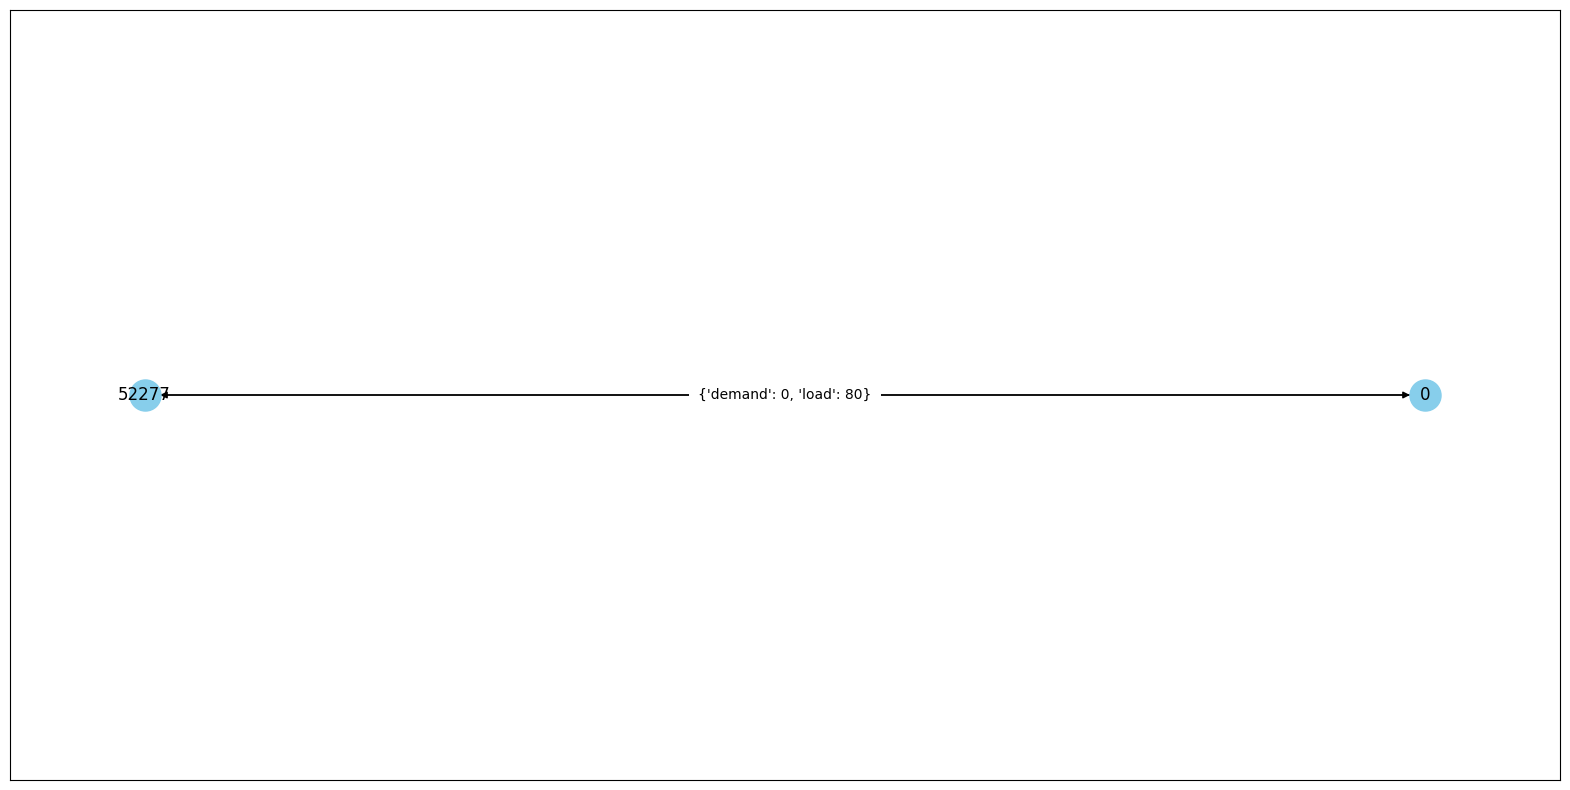



Bus 2:


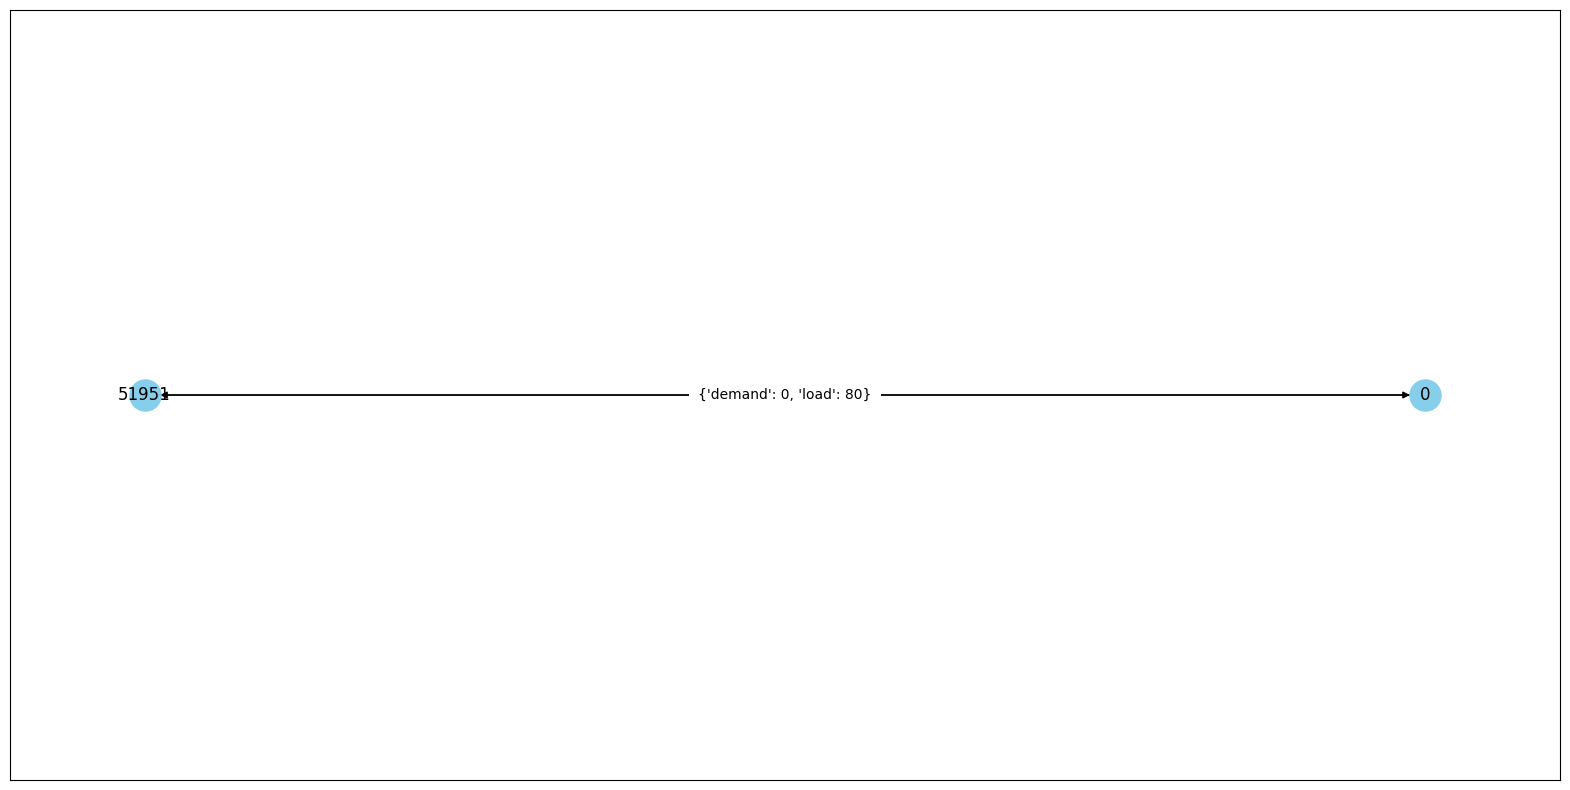



Bus 4:


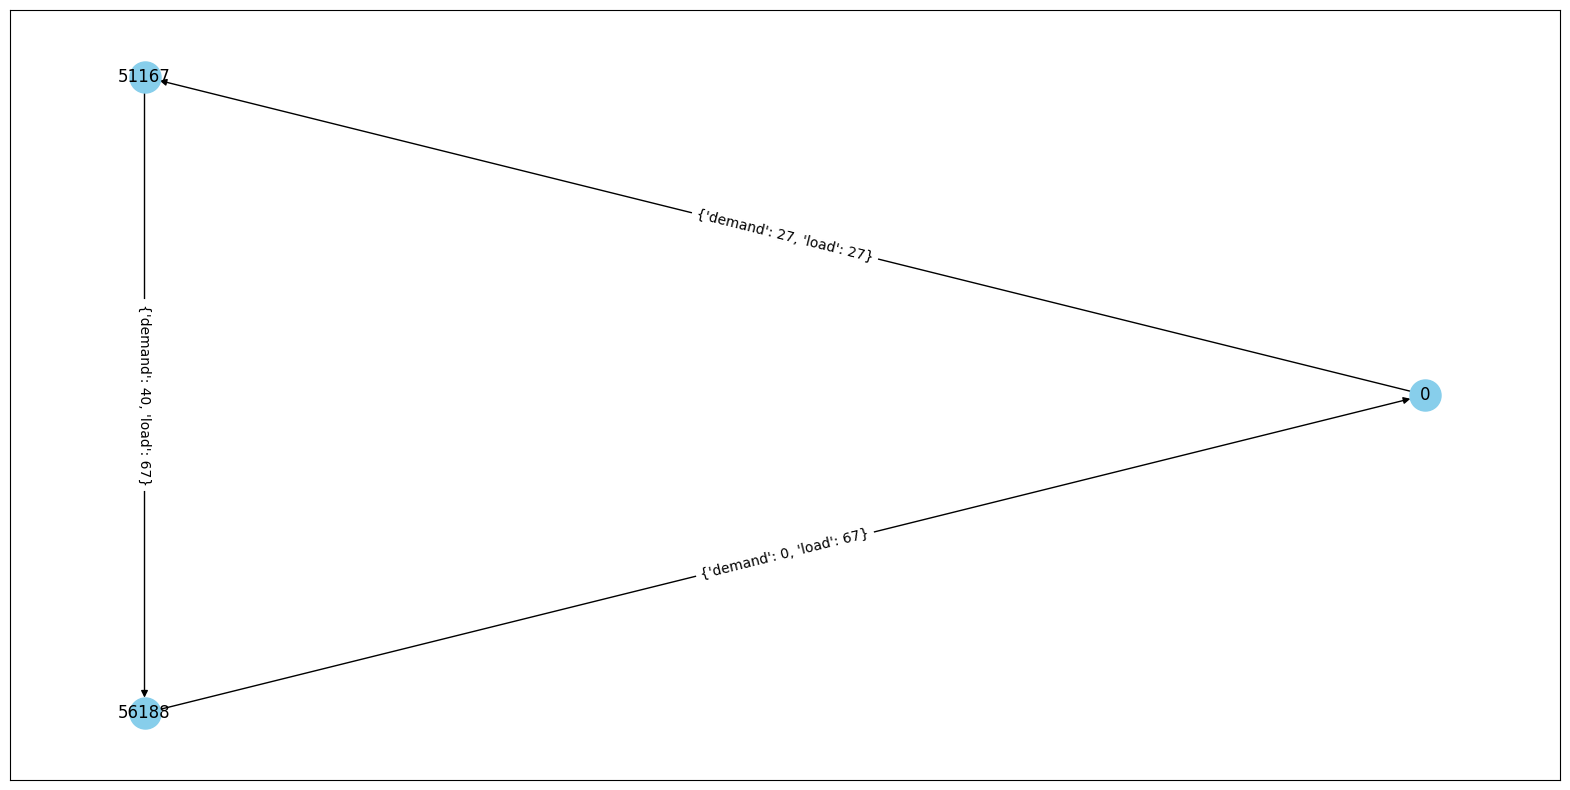



Bus 5:


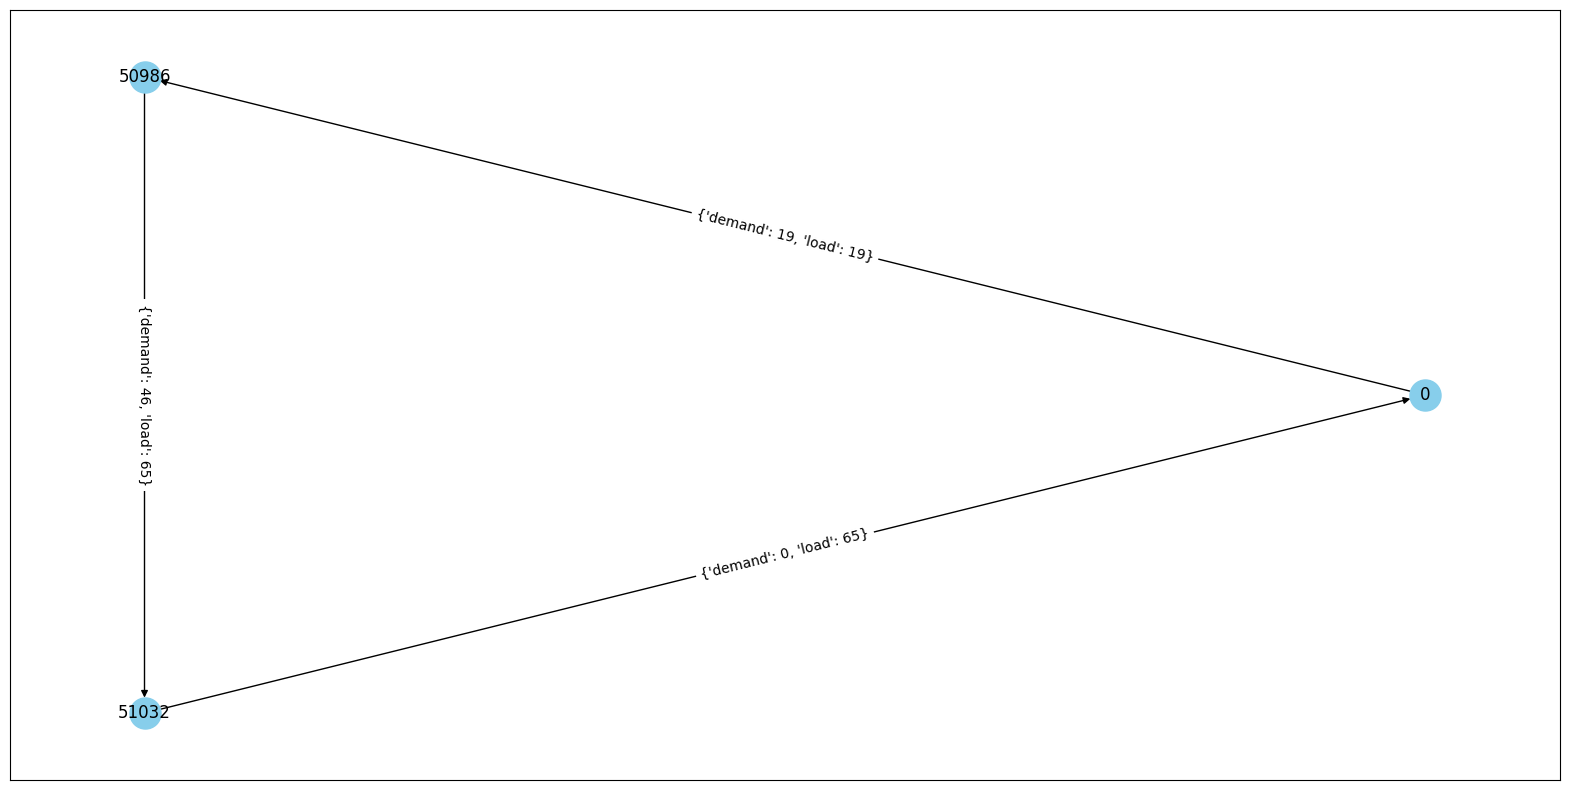



Bus 6:


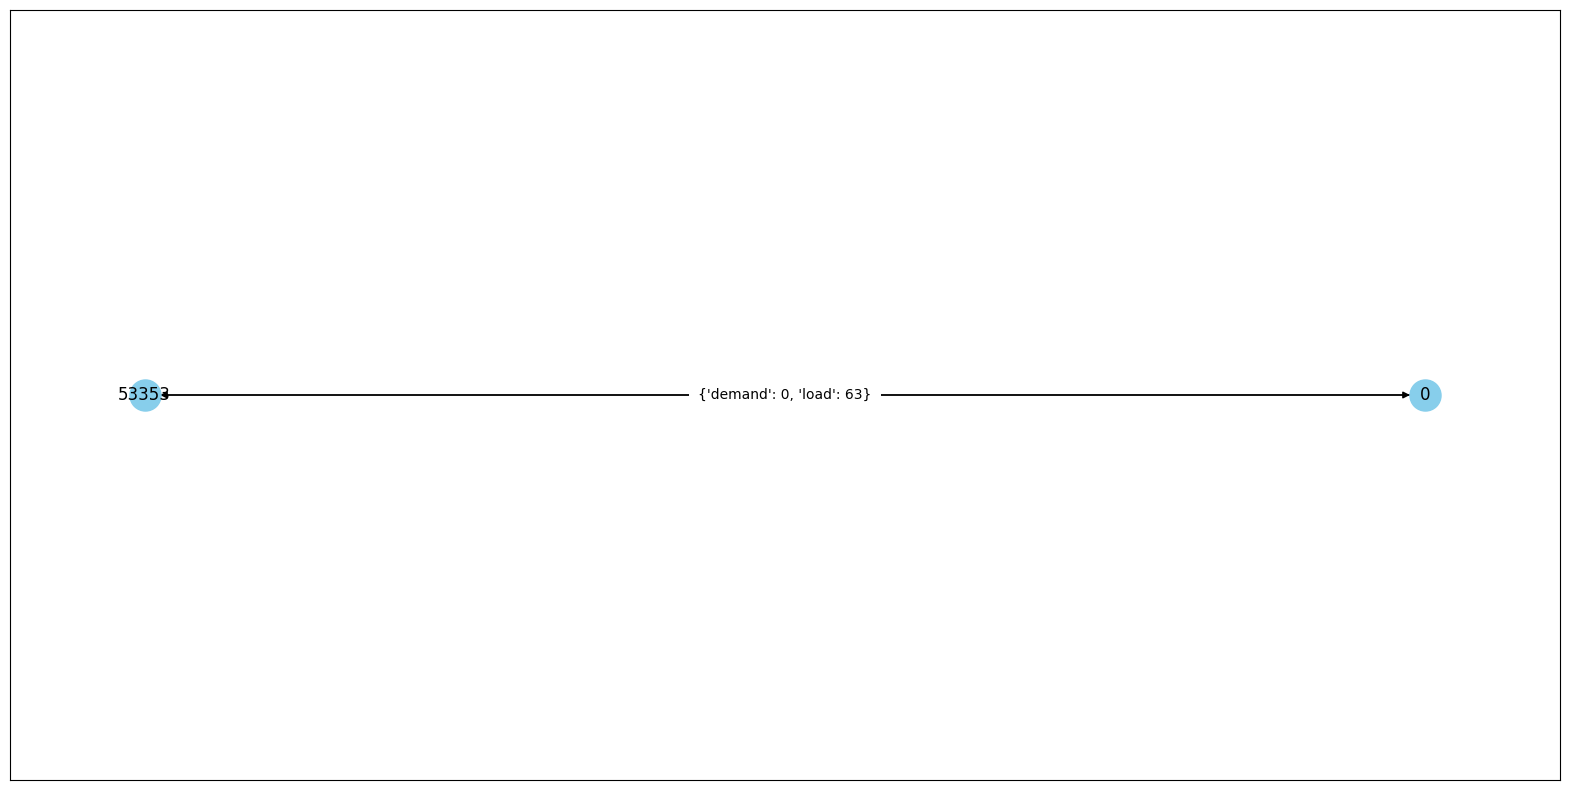



Bus 7:


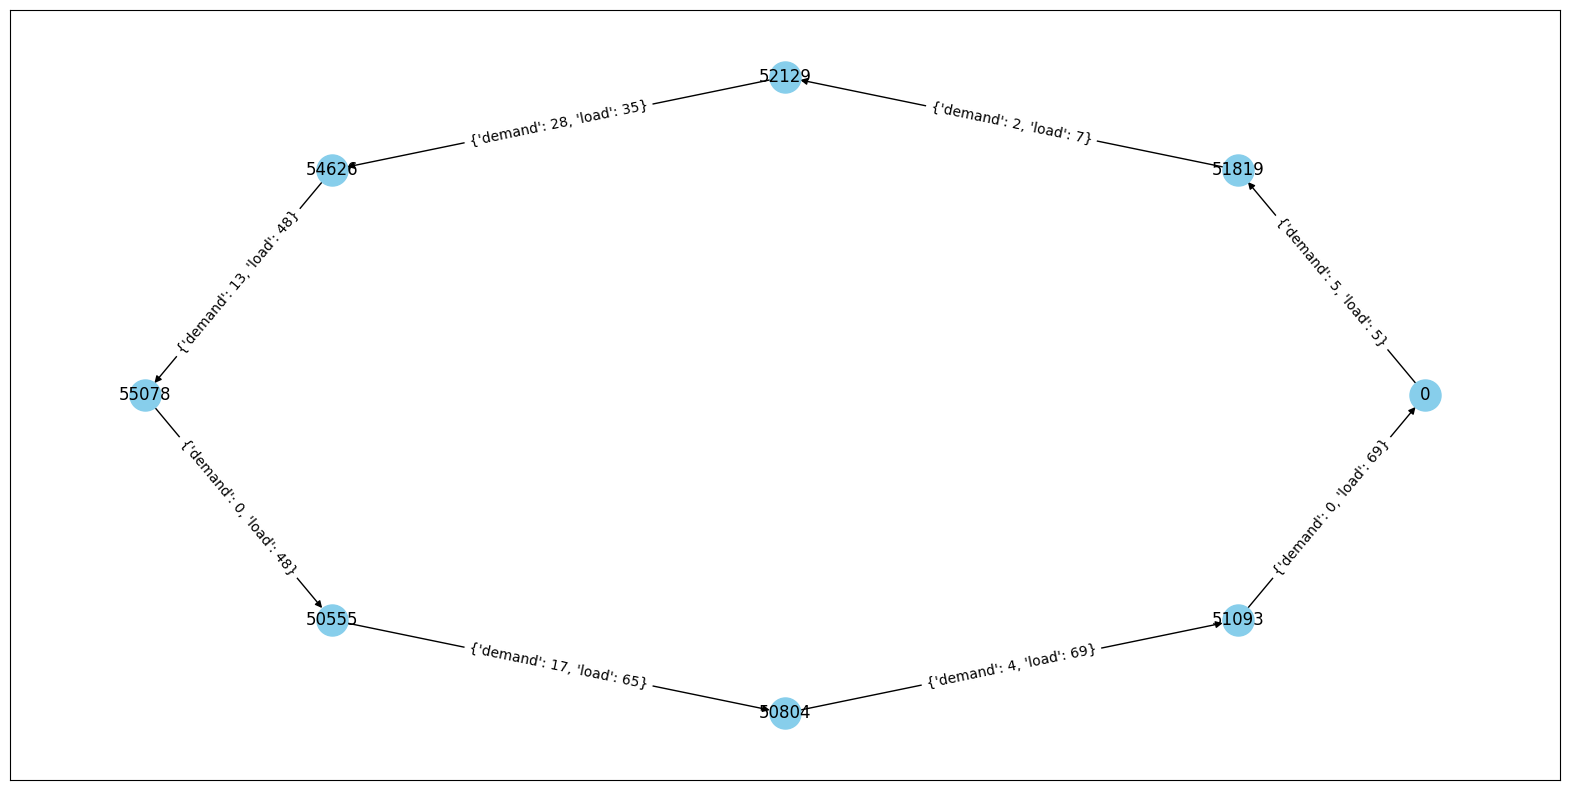



Bus 11:


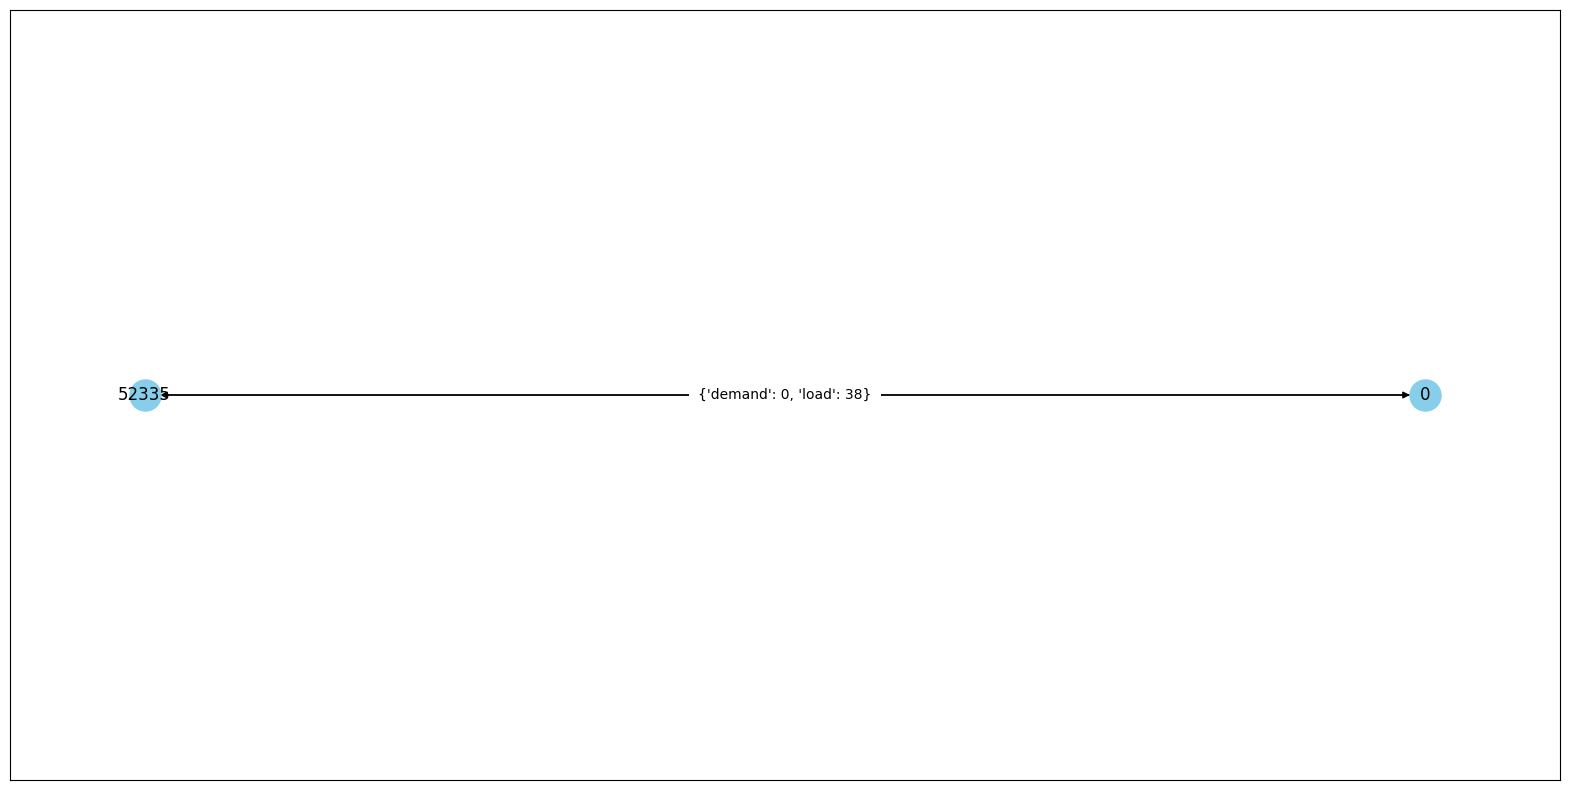



Bus 12:


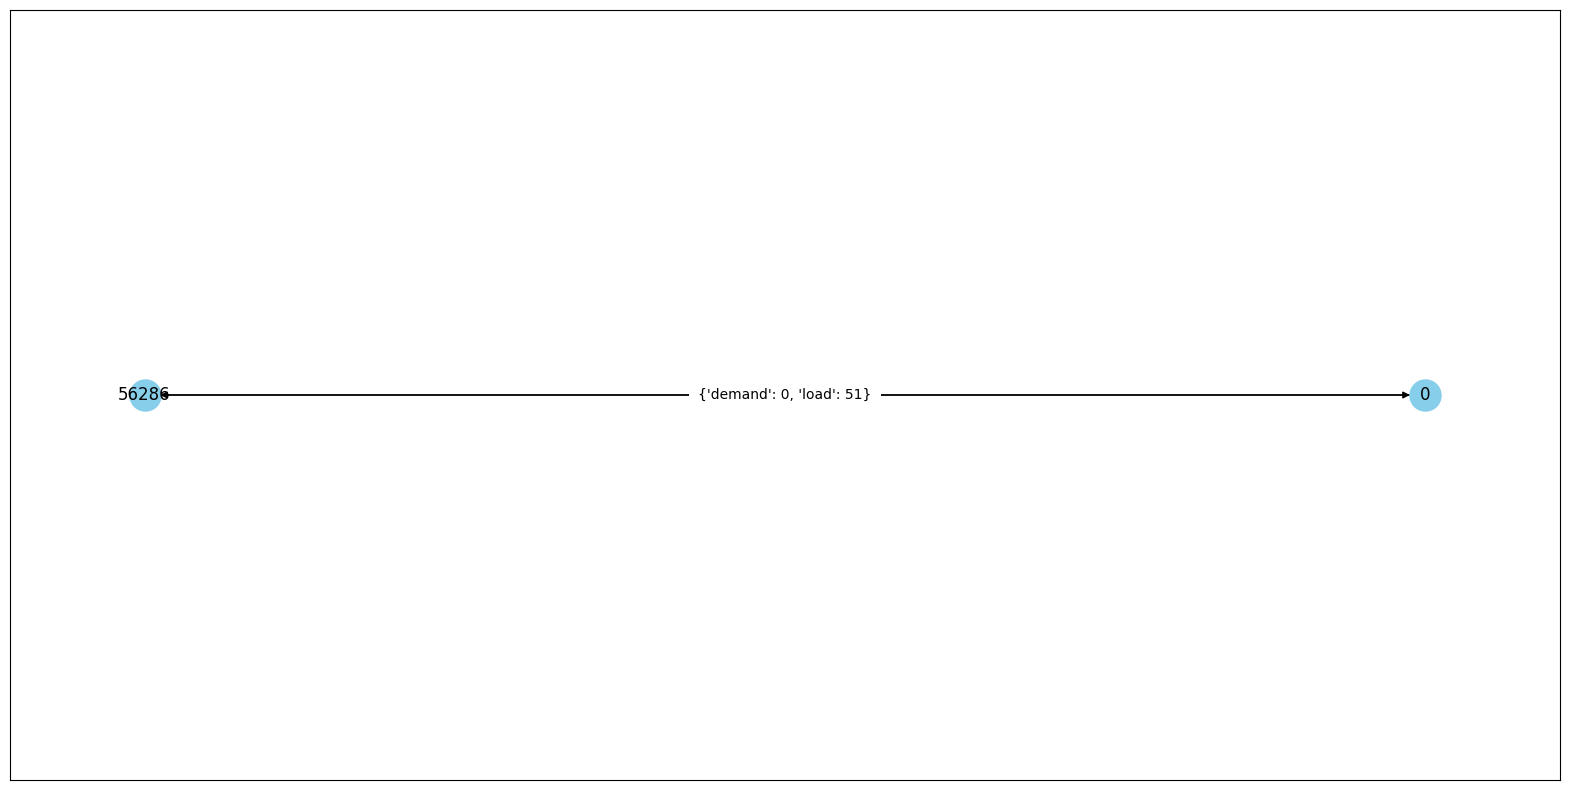



Bus 14:


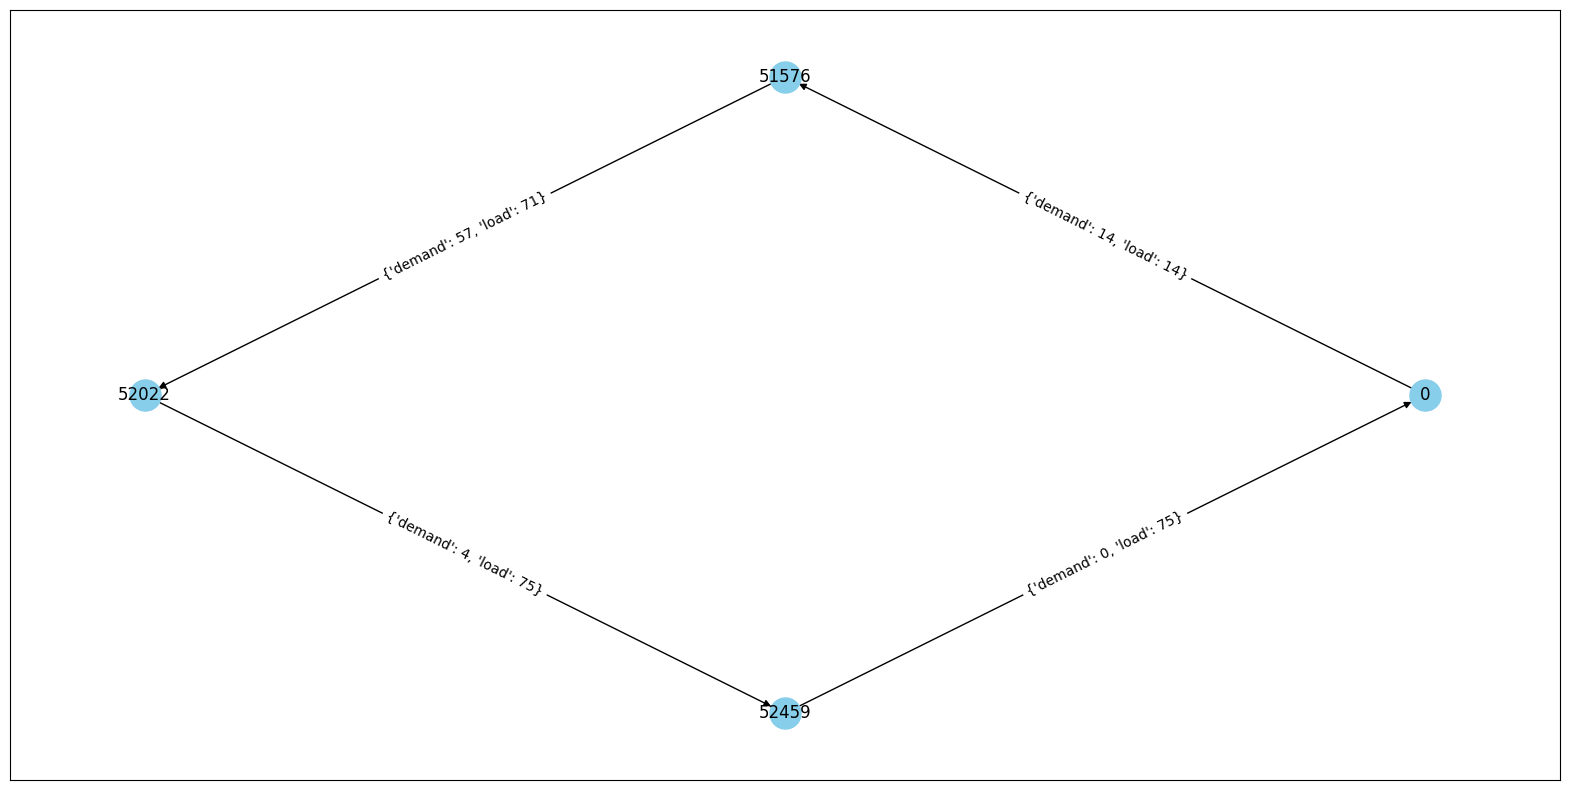

In [85]:
for bus in bus_path_df.bus.unique():
    print(f"Bus {bus + 1}:")

    bus_route = bus_path_df[bus_path_df["bus"] == bus].reset_index(drop=True)

    plt.figure(figsize=(20, 10))

    g = nx.DiGraph()

    for segment in bus_route.itertuples():
        g.add_edge(
            segment.start_stop,
            segment.end_stop,
            weight=segment.distance,
            demands={"demand": segment.demand, "load": segment.step_demand},
            step=segment.step,
            label=f"{segment.start_stop}-{segment.end_stop}",
            load=segment.step_demand,
        )

    pos = nx.circular_layout(g)

    nx.draw_networkx(g, pos, with_labels=True, node_size=500, node_color="skyblue")
    nx.draw_networkx_edge_labels(
        g, pos, edge_labels=nx.get_edge_attributes(g, "demands")
    )

    plt.show()

    print("\n")

In [86]:
routes_gdf = (
    gpd.GeoDataFrame(bus_path_df.groupby("bus")["geometry"].apply(list))
    .rename(columns={"points": "geometry"})
    .reset_index()
)

# add depot to each geometry
routes_gdf["points"] = routes_gdf.apply(
    lambda x: [Point((float(depot.stop_lon), float(depot.stop_lat)))] + x.geometry,
    axis=1,
)

routes_gdf["geometry"] = routes_gdf["points"].apply(LineString)
routes_gdf.drop(columns=["points"], inplace=True)

routes_gdf = routes_gdf.merge(
    bus_path_df.groupby("bus")["demand"].sum().rename("demand").reset_index(),
    on="bus",
)

routes_gdf = gpd.GeoDataFrame(routes_gdf, geometry="geometry")
routes_gdf.crs = "EPSG:4326"

display(routes_gdf)

,bus,geometry,demand
0,0,"LINESTRING (-73.56912 45.50485, -73.57663 45.5...",80
1,1,"LINESTRING (-73.56912 45.50485, -73.58804 45.4...",80
2,3,"LINESTRING (-73.56912 45.50485, -73.62216 45.4...",67
3,4,"LINESTRING (-73.56912 45.50485, -73.63058 45.4...",65
4,5,"LINESTRING (-73.56912 45.50485, -73.52561 45.5...",63
5,6,"LINESTRING (-73.56912 45.50485, -73.59108 45.5...",69
6,10,"LINESTRING (-73.56912 45.50485, -73.57477 45.5...",38
7,11,"LINESTRING (-73.56912 45.50485, -73.59190 45.4...",51
8,13,"LINESTRING (-73.56912 45.50485, -73.60201 45.5...",75


### Map the routes

In [87]:
colormap_route = [
    mcolors.rgb2hex(c) for c in list(plt.cm.rainbow(np.linspace(0, 1, num_buses)))
]

route_map = folium.Map(
    location=[45.5048542, -73.5691235],
    zoom_start=11,
    tiles="cartodbpositron",
    width="100%",
)

folium.GeoJson(
    disaster_area,
    name="Disaster area",
    style_function=lambda x: {
        "color": "#ff0000",
        "fillColor": "#ff0000",
        "weight": 1,
        "fillOpacity": 0.3,
    },
).add_to(route_map)

for stop in bus_path_df.itertuples():
    folium.CircleMarker(
        location=[stop.geometry.coords[0][1], stop.geometry.coords[0][0]],
        radius=5,
        color=colormap_route[stop.bus] if stop.stop_id != "0" else "black",
        fill=True,
        fill_opacity=1,
        fill_color=colormap_route[stop.bus] if stop.stop_id != "0" else "black",
        tooltip=f"""
        <b>{stop.stop_name} ({stop.stop_id})</b>
        <br>
        Route: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['bus'].values[0] + 1}
        <br>
        Step: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['step'].values[0] + 1}
        <br>
        Demand: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['demand'].values[0]}
        <br>
        Load: {bus_path_df[bus_path_df["stop_id"] == stop.stop_id]['step_demand'].values[0]}
        """,
        popup=f"""
        <div>
            <h4>{stop.stop_name} ({stop.stop_id})</h4>
            <h4>Distance from depot: {distance_matrix.loc["0", stop.stop_id]:.1f} km</h4>
        </div>
        """,
    ).add_to(route_map)

for stop in stops_in_disaster_area.itertuples():
    folium.CircleMarker(
        location=[stop.geometry.coords[0][1], stop.geometry.coords[0][0]],
        radius=5,
        color="red",
        fill=True,
        fill_opacity=1,
        fill_color="red",
        tooltip=f"""
        <b>{stop.stop_name} ({stop.stop_id})</b>
        """,
        popup=f"""
        <div>
            <h4>{stop.stop_name} ({stop.stop_id})</h4>
            <h4>Distance from depot: {distance_matrix.loc["0", stop.stop_id]:.1f} km</h4>
        </div>
        """,
    ).add_to(route_map)


for route in routes_gdf.itertuples():
    route_layer = folium.FeatureGroup(f"Route {route.bus + 1}")
    folium.PolyLine(
        locations=[(p[1], p[0]) for p in route.geometry.coords],
        color=colormap_route[route.bus],
        weight=3,
        opacity=0.6,
        tooltip=f"Route {route.bus + 1}",
        popup=f"""
        <div>
            <h5>Route {route.bus + 1}</h5>
            <h5>Total demand: {route.demand}</h5>
        </div>
        """,
    ).add_to(route_layer)

    route_layer.add_to(route_map)

folium.plugins.Fullscreen(position="topright").add_to(route_map)
folium.plugins.MousePosition(position="topright").add_to(route_map)
folium.LayerControl().add_to(route_map)

route_map.save("route_map_geometric_split.html")
route_map